In [26]:
a = [[1],[2],[3]]
b = copy(a)
for i in 1:3
    b[i] .+= 2
end
a

3-element Vector{Vector{Int64}}:
 [3]
 [4]
 [5]

In [20]:
using Yao, FLOYao

nq = 2
circuit = chain(nq)
push!(circuit, rot(kron(nq, 1 => X, 2 => X), 0.))
println(circuit)
param = rand()*2π 
dispatch!(circuit, param)
println(circuit)
println(param)
println(cos(param/2))
println(-sin(param/2))
r = Yao.zero_state(nq) |> circuit 
r |> statevec |> println
ham = kron(nq, 1 => Z)
println(ham)
println(cos(param))
expect(ham, r)
function f(reg)
    return expect'(ham, reg => g)[2]
end

nqubits: 2
chain
└─ rot(nqubits: 2
kron
├─ 1=>X
└─ 2=>X, 0.0)
nqubits: 2
chain
└─ rot(nqubits: 2
kron
├─ 1=>X
└─ 2=>X, 2.4543939193017965)
2.4543939193017965
0.33687824474746414
-0.9415482187418059
ComplexF64[0.33687824474746414 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 - 0.9415482187418059im]
nqubits: 2
kron
└─ 1=>Z
-0.7730260964317354


-0.7730260964317353

In [113]:
using Yao, FLOYao

blk = kron(-kron(-kron(nq,1=>Z)))
locs = collect(Iterators.flatten(blk.locs))
perm = sortperm(locs)
println(blk.blocks[1] |> typeof)
println(perm)
println(blk |> typeof)
FLOYao.kron2majoranaindices(blk)

Scale{Val{-1}, 2, KronBlock{2, 1, Tuple{Scale{Val{-1}, 2, KronBlock{2, 1, Tuple{ZGate}}}}}}
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
KronBlock{2, 1, Tuple{Scale{Val{-1}, 2, KronBlock{2, 1, Tuple{Scale{Val{-1}, 2, KronBlock{2, 1, Tuple{ZGate}}}}}}}}


FLOYao.NonFLOException: NonFLOException: (nqubits: 10
[-] kron
   └─ 1:10=>[-] kron
         └─ 1=>Z
,) acting on (1:10,) is not FLO

In [102]:
using Yao, FLOYao, LinearAlgebra

function majoranaindices2kron(nq, i, j) #Returns γ_iγ_j, ASSUME i<j (ok i actually have no clue what's going on due to conflicts in definition of γ_i (FLOYao docs vs Jozsa Miyake paper vs Bill's paper))
    p = []
    c = (i % 2 == j % 2) ? 1 : -1 #deal with this c later..., once i figure out how to scale kronblocks so that they stay as kronblock objects...
    #it's fine, this outputs an Add object now so i can pass it through expect'
    a = min(i, j)
    b = max(i, j)
    first = (a+1) ÷ 2 
    last = (b+1) ÷ 2 
    if first == last #This means i=j-1 and j is even
        c = 1
        push!(p, first => -Z)
    else
        if i % 2 == 0
            push!(p, first => X)
            c *= 1
        else
            push!(p, first => Y)
            c *= -1
        end
        for k in first+1:last-1
            push!(p, k => Z)
            c *= -1
        end
        if j % 2 == 0
            push!(p, last => Y)
        else
            push!(p, last => X)
        end
    end
    return c*kron(nq, p...)
end

function majorana_commutator(nq, i, j)
    return majoranaindices2kron(nq, i, j) + 0*kron(nq, 1 => Z)
end

blk = kron(majoranaindices2kron(4,1,2))
blk
FLOYao.kron2majoranaindices(blk)

FLOYao.NonFLOException: NonFLOException: ([-] Z,) acting on (1:1,) is not FLO

In [42]:
using BenchmarkTools
using Yao, FLOYao
using LinearAlgebra

N = 10

nq = 10
layers = 2
g = chain(nq)
for _ in 1:layers
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => X), 0.))
    end
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => Y), 0.))
    end
    for i in 1:nq
        push!(g, put(nq, i => Rz(0.)))
    end
end

⊗ = kron

function covariance_matrix(reg::MajoranaReg)
    nq = nqubits(reg)
    G = I(nq) ⊗ [0 1; -1 0]
    return reg.state * G * reg.state'
end

function huh!(b, temp_m, probabilities) #Evolves all matrices and probabilities and gradients by nq steps, in-place and optimally
    nq = N
    dim = 2*nq
    for i in 2:nq
        i1 = 2*(i-1)
        ni = b[i-1]
        cur_prob = probabilities[i-1]
        cur_prefactor = (-1)^ni / (2*cur_prob)
        for p in 2*(i-1)+1:dim
            for q in p+1:dim
                temp_m[p,q] -= cur_prefactor * (temp_m[i1-1,p] * temp_m[i1,q])
                temp_m[p,q] += cur_prefactor * (temp_m[i1-1,q] * temp_m[i1,p])
            end
        end
        ni = b[i]
        probabilities[i] = (1+(-1)^ni * temp_m[i1+1, i1+2]) / 2
    end
end

function update_opt!(reg::MajoranaReg, theta, b, temp_m, probabilities) #Evolves all matrices and probabilities and gradients by nq steps, in-place and optimally
    nq = nqubits(reg)
    nparams = nparameters(g)
    dim = 2*nq
    t_tot = 0
    for i in 1:2
        if i > 1
            t = time()
            huh!(b, temp_m, probabilities)
            diff = (time() - t) * 10^6
            println("iteration $i : $diff")
        else
            i1 = 0
            dispatch!(g, theta)
            z = reg |> g
            temp_m = covariance_matrix(z)
            ni = b[i]
            probabilities[i] = (1+(-1)^ni * temp_m[i1+1, i1+2]) / 2
        end
        # diff = (time() - t) * 10^6
        # t_tot += diff
        # println("iteration $i: $diff")
    end
    # println("total time: $t_tot")
end

bitstr = rand(Bool, N)
prob = Vector{Float64}(undef, N)
prob[1] = rand() #JUST TESTING huh!, this represents the probabilities vector, not the params of g
p = rand(nparameters(g)).*2π
dispatch!(g, p)
println("number of parameters: ", nparameters(g))
reg = FLOYao.zero_state(nq) |> g
results = measure(reg, nshots = 1)
bitstr = results[1]
println("measured outcome: $bitstr")
println("probability of measuring the above outcome: ", FLOYao.bitstring_probability(reg, bitstr))

dim = 2*nq
temp_m = Matrix{Float64}(undef, dim, dim)
probabilities = Vector{Float64}(undef, nq)
# prob(FLOYao.zero_state(nq), p, bitstr, temp_m, probabilities)
# update_opt!(FLOYao.zero_state(nq), p, bitstr, temp_m, probabilities)
# @benchmark huh!(bitstr, rand(dim, dim), prob) #800 microsec
# update_opt!(FLOYao.zero_state(N), p, bitstr, temp_m, probabilities)
update_opt!(FLOYao.zero_state(N), p, bitstr, temp_m, probabilities)

number of parameters: 56
measured outcome: 1011000001 ₍₂₎
probability of measuring the above outcome: 0.002515503462413642488555028511800403689413551674951671089462360038403364608074197
iteration 2 : 27250.051498413086


In [ ]:
# number of parameters: 56
# measured outcome: 1010101101 ₍₂₎
# probability of measuring the above outcome: 0.002360660013418328876523065726568606080691889830618951769765871877112546743484876
# iteration 1: 8805.990219116211
# iteration 2: 22840.023040771484
# total time: 31646.013259887695

In [5]:
using BenchmarkTools

a = rand(20, 20)

function gg(i, a)
    i1 = 2*(i-1)
    cur_prefactor = -1/(2*rand())
    for p in 2*(i-1)+1:dim
        for q in p+1:dim
            a[p,q] -= cur_prefactor * (a[i1-1,p] * a[i1,q])
            a[p,q] += cur_prefactor * (a[i1-1,q] * a[i1,p])
        end
    end
    return a
end

function ggg(a)
    for i in 2:10
        gg(i, a)
    end
    return a
end

@benchmark ggg(a)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  229.125 μs …   5.128 ms  ┊ GC (min … max): 0.00% … 94.39%
 Time  (median):     233.125 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   243.442 μs ± 121.536 μs  ┊ GC (mean ± σ):  2.53% ±  4.84%

  ▂▂ ▇█▅▄▅▄▃▃▂▂▂▁▂▂▁▃▄▃▃▂▂▁                                     ▂
  ████████████████████████████▇▇▇▆▇▆▆▆▅▆▅▅▅▆▅▅▄▂▃▃▅▂▄▅▄▄▄▄▃▄▃▂▅ █
  229 μs        Histogram: log(frequency) by time        279 μs <

 Memory estimate: 137.16 KiB, allocs estimate: 8064.

In [31]:
using Yao, FLOYao, BenchmarkTools, LinearAlgebra

nq = 10
layers = 2
g = chain(nq)
for _ in 1:layers
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => X), 0.))
    end
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => Y), 0.))
    end
    for i in 1:nq
        push!(g, put(nq, i => Rz(0.)))
    end
end

⊗ = kron

function covariance_matrix(reg::MajoranaReg)
    nq = nqubits(reg)
    G = I(nq) ⊗ [0 1; -1 0]
    return reg.state * G * reg.state'
end

function update_opt!(reg::MajoranaReg, theta, b, temp_m, probabilities) #Evolves all matrices and probabilities and gradients by nq steps, in-place and optimally
    nq = nqubits(reg)
    nparams = nparameters(g)
    dim = 2*nq
    t_tot = 0
    for i in 1:nq
        i1 = 2*(i-1)
        t = time()
        if i > 1
            ni = b[i-1]
            cur_prob = probabilities[i-1]
            cur_prefactor = (-1)^ni / (2*cur_prob)
            t = time()
            for p in 2*(i-1)+1:dim
                for q in p+1:dim
                    temp_m[p,q] -= cur_prefactor * (temp_m[i1-1,p] * temp_m[i1,q])
                    temp_m[p,q] += cur_prefactor * (temp_m[i1-1,q] * temp_m[i1,p])
                end
            end
            ni = b[i]
            probabilities[i] = (1+(-1)^ni * temp_m[i1+1, i1+2]) / 2
        else
            t = time()
            dispatch!(g, theta)
            z = reg |> g
            temp_m = covariance_matrix(z)
            ni = b[i]
            probabilities[i] = (1+(-1)^ni * temp_m[i1+1, i1+2]) / 2
        end
        diff = (time() - t) * 10^6
        t_tot += diff
        println("iteration $i: $diff")
    end
    println("total time: $t_tot")
end

function prob(reg::MajoranaReg, theta, b, temp_m, probabilities)
    nq = nqubits(reg)
    update_opt!(reg, theta, b, temp_m, probabilities)
    return prod(probabilities)
end

iters = 1
p = rand(nparameters(g)).*2π
dispatch!(g, p)
println("number of parameters: ", nparameters(g))
reg = FLOYao.zero_state(nq) |> g
results = measure(reg, nshots = iters)
bitstr = results[1]
println("measured outcome: $bitstr")
println("probability of measuring the above outcome: ", FLOYao.bitstring_probability(reg, bitstr))
T = Float64

println("type: $T")
dim = 2*nq
temp_m = Matrix{T}(undef, dim, dim)
probabilities = Vector{T}(undef, nq)
# prob(FLOYao.zero_state(nq), p, bitstr, temp_m, probabilities)
update_opt!(FLOYao.zero_state(nq), p, bitstr, temp_m, probabilities)

number of parameters: 56
measured outcome: 1000000001 ₍₂₎
probability of measuring the above outcome: 0.01045388618801599602654681368141880519085148814234172450423362156621319723598039
type: Float64
iteration 1: 281584.0244293213
iteration 2: 355.9589385986328
iteration 3: 195.98007202148438
iteration 4: 150.91896057128906
iteration 5: 109.91096496582031
iteration 6: 74.86343383789062
iteration 7: 46.96846008300781
iteration 8: 27.179718017578125
iteration 9: 12.874603271484375
iteration 10: 3.814697265625
total time: 282562.4942779541


In [16]:
using BenchmarkTools

N = 56
c = rand()
a = rand(5)
b = rand(N)
d = rand(N)
e = rand(N)
print(a)
@benchmark $c * ((-b * a[2] * a[3]) .+ (a[4] * (d * a[3] .+ a[2] * e)))

BenchmarkTools.Trial: 10000 samples with 10 evaluations.
 Range (min … max):  1.371 μs … 191.071 μs  ┊ GC (min … max): 0.00% … 96.29%
 Time  (median):     1.462 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.705 μs ±   4.409 μs  ┊ GC (mean ± σ):  8.04% ±  3.18%

  ▃██▇▅▆▅▄▃▁▁▁▁▂▂▂▁▁▁                                         ▂
  ███████████████████████▇▇▇▆▆▅▅▅▅▅▅▅▅▅▄▄▅▄▅▄▅▅▄▄▃▄▃▁▁▃▁▁▁▁▁▃ █
  1.37 μs      Histogram: log(frequency) by time      3.24 μs <

 Memory estimate: 5.00 KiB, allocs estimate: 19.

In [19]:
cur_prefactor = (-1)^ni / (2*rand())
temp_m = rand(30,30)
@benchmark cur_prefactor * (temp_m[18,21] * temp_m[19,20])

BenchmarkTools.Trial: 10000 samples with 883 evaluations.
 Range (min … max):  130.144 ns …  10.812 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     133.069 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   140.220 ns ± 160.660 ns  ┊ GC (mean ± σ):  1.16% ± 2.98%

  ▂▁▇██▇▅▃▄▃▃▃▄▄▃▃▂▂▂▂▂▂▂▁▁                                     ▂
  █████████████████████████████▇▇▇▇▆▆▇▆▇█▇▇▇▆▆▇▇▇▇▇▇▆▆▆▆▆▅▆▅▅▆▅ █
  130 ns        Histogram: log(frequency) by time        166 ns <

 Memory estimate: 64 bytes, allocs estimate: 4.

In [ ]:
using Yao, FLOYao

using LinearAlgebra
using Random
using Yao
using BenchmarkTools

nq = 10
layers = 2
g = chain(nq)
for _ in 1:layers
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => Y), 0.))
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    # Not needed YY = XX and IZ and ZI
    for i in 1:nq
        push!(g, put(nq, i => Rz(0.)))
    end
end

⊗ = kron

function covariance_matrix(reg::MajoranaReg)
    nq = nqubits(reg)
    G = I(nq) ⊗ [0 1; -1 0]
    return reg.state * G * reg.state'
end

function majoranaindices2kron(nq, i, j) #Returns γ_iγ_j, ASSUME i<j (ok i actually have no clue what's going on due to conflicts in definition of γ_i (FLOYao docs vs Jozsa Miyake paper vs Bill's paper))
    p = []
    c = (i % 2 == j % 2) ? 1 : -1 #deal with this c later..., once i figure out how to scale kronblocks so that they stay as kronblock objects...
    #it's fine, this outputs an Add object now so i can pass it through expect'
    a = min(i, j)
    b = max(i, j)
    first = (a+1) ÷ 2 
    last = (b+1) ÷ 2 
    if first == last #This means i=j-1 and j is even
        c = -im
        push!(p, first => Z)
    else
        if i % 2 == 0
            push!(p, first => X)
            c *= -im
        else
            push!(p, first => Y)
            c *= im
        end
        for k in first+1:last-1
            push!(p, k => Z)
            c *= -1
        end
        if j % 2 == 0
            push!(p, last => Y)
        else
            push!(p, last => X)
        end
    end
    return c*kron(nq, p...)
end

function majorana_commutator(nq, i, j)
    return im*majoranaindices2kron(nq, i, j) + 0*kron(nq, 1 => Z)
end 

nparams = nparameters(g)
dim = 2*nq
sampled = Dict{BitStr, Vector}() #Keeps track of which x has been sampled before, so it doesn't recompute everything  (NOT REALLY SURE IF THIS WILL WORK WELL...)

function update_opt!(reg::MajoranaReg, theta, b, temp_m, temp_grad_m, probabilities, grad_probabilities) #Evolves all matrices and probabilities and gradients by nq steps, in-place and optimally
    nq = nqubits(reg)
    nparams = nparameters(g)
    dim = 2*nq
    t_tot = 0
    for i in 1:nq
        t = time()
        if i > 1
            ni = b[i-1]
            cur_prob = probabilities[i-1]
            cur_grad_prob = grad_probabilities[:, i-1]
            cur_prefactor = (-1)^ni / (2*cur_prob)
            cur_grad_prefactor = cur_prefactor / cur_prob
            i1 = 2*(i-1)-1
            i2 = i1+1
            for p in 2*(i-1)+1:dim
                for q in p+1:dim
                    record = (p == dim - 1) && (q == dim)
                    if record
                        tt = time()
                    end
                    k1 = temp_m[i1,p]
                    k2 = temp_m[i2,q]
                    k3 = temp_m[i1,q]
                    k4 = temp_m[i2,p]
                    v1 = temp_grad_m[:,i1,p]
                    v2 = temp_grad_m[:,i2,q]
                    v3 = temp_grad_m[:,i1,q]
                    v4 = temp_grad_m[:,i2,p]
                    if record
                        diff = time() - tt
                        # println("memory access time: $diff")
                        tt = time()
                    end
                    temp_grad_m[:,p,q] .-= cur_grad_prefactor * ((cur_grad_prob * k1 * k2) .+ (cur_prob * (v1 * k2 .+ k1 * v2)))
                    temp_grad_m[:,p,q] .+= cur_grad_prefactor * ((cur_grad_prob * k3 * k4) .+ (cur_prob * (v3 * k4 .+ k3 * v4)))
                    if record
                        diff = time() - tt
                        # println("calculation time: $diff")
                    end   
                end
            end
            for p in 2*(i-1)+1:dim
                for q in p+1:dim
                    temp_m[p,q] -= cur_prefactor * (temp_m[i1,p] * temp_m[i2,q]) 
                    temp_m[p,q] += cur_prefactor * (temp_m[i1,q] * temp_m[i2,p])
                end
            end
            ni = b[i]
            probabilities[i] = (1+(-1)^ni * temp_m[2*i-1, 2*i]) / 2
            grad_probabilities[:, i] = (-1)^ni * temp_grad_m[:,2*i-1, 2*i] / 2
        else
            dispatch!(g, theta)
            z = reg |> g
            temp_m = covariance_matrix(z)
            ni = b[i]
            probabilities[i] = (1+(-1)^ni * temp_m[2*i-1, 2*i]) / 2
            for p in 1:dim
                for q in p+1:dim
                    ham = majorana_commutator(nq, p, q)
                    temp_grad_m[:,p,q] = expect'(ham, reg => g)[2]
                end
            end
            grad_probabilities[:, i] = (-1)^ni * temp_grad_m[:,2*i-1, 2*i] / 2
        end
        diff = time() - t
        t_tot += diff
        println("iteration $i: $diff")
    end
    println("total time: $t_tot")
end

function log_grad_opt(reg::MajoranaReg, theta, b, temp_m, temp_grad_m, probabilities, grad_probabilities)
    nq = nqubits(reg)
    update_opt!(reg, theta, b, temp_m, temp_grad_m, probabilities, grad_probabilities)
    s = zeros(length(theta))
    for i in 1:nq
        s += grad_probabilities[:, i] / probabilities[i]
    end
    optimized_prob = probabilities
    return optimized_prob, s
end

# iters = 1
# p = rand(nparameters(g)).*2π
# dispatch!(g, p)
# reg = FLOYao.zero_state(nq) |> g
# results = measure(reg, nshots = iters)
# bitstr = results[1]
# println("measured outcome: $bitstr")
# println("probability of measuring the above outcome: ", FLOYao.bitstring_probability(reg, bitstr))

T = Float64
println("type: $T")
temp_m = Matrix{T}(undef, dim, dim)
temp_grad_m = Array{T}(undef, nparams, dim, dim)
probabilities = Vector{T}(undef, nq)
grad_probabilities = Matrix{T}(undef, nparams, nq)
optimized_prob, optimized = log_grad_opt(FLOYao.zero_state(nq), p, bitstr, temp_m, temp_grad_m, probabilities, grad_probabilities)
optimized;
println("probabilities equal? ", basic_prob == optimized_prob)
println("grad(log p) equal? ", basic == optimized)

In [ ]:
using Yao, FLOYao

using LinearAlgebra
using Random
using SparseArrays
using Yao
using BenchmarkTools

nq = 3
layers = 2
g = chain(nq)
for _ in 1:layers
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => Y), 0.))
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    # Not needed YY = XX and IZ and ZI
    for i in 1:nq
        push!(g, put(nq, i => Rz(0.)))
    end
end


⊗ = kron

function covariance_matrix(reg::MajoranaReg)
    nq = nqubits(reg)
    G = I(nq) ⊗ [0 1; -1 0]
    return reg.state * G * reg.state'
end

function majoranaindices2kron(nq, i, j) #Returns γ_iγ_j, ASSUME i<j (ok i actually have no clue what's going on due to conflicts in definition of γ_i (FLOYao docs vs Jozsa Miyake paper vs Bill's paper))
    p = []
    c = (i % 2 == j % 2) ? 1 : -1 #deal with this c later..., once i figure out how to scale kronblocks so that they stay as kronblock objects...
    a = min(i, j)
    b = max(i, j)
    first = (a+1) ÷ 2 
    last = (b+1) ÷ 2 
    if first == last #This means i=j-1 and j is even
        c = -2*im
        push!(p, first => Z)
    else
        if i % 2 == 0
            push!(p, first => X)
            c *= -im
        else
            push!(p, first => Y)
            c *= im
        end
        for k in first+1:last-1
            push!(p, k => Z)
            c *= -1
        end
        if j % 2 == 0
            push!(p, last => Y)
        else
            push!(p, last => X)
        end
    end
    return kron(nq, p...)
end

function majorana_commutator(nq, i, j)
    return -2*majoranaindices2kron(nq, i, j) + 0*kron(nq, 1 => Z)
end

nparams = nparameters(g)
dim = 2*nq
sampled = Dict{BitStr, Vector}() #Keeps track of which x has been sampled before, so it doesn't recompute everything  (NOT REALLY SURE IF THIS WILL WORK)

function update!(reg::MajoranaReg, theta, b, temp_m, temp_grad_m, cur_m, cur_grad_m, probabilities, grad_probabilities) #Evolves all matrices and probabilities and gradients by nq steps, in-place
    nq = nqubits(reg)
    nparams = nparameters(g)
    dim = 2*nq
    for i in 1:nq
        ni = b[i]
        if stored > 0
            cur_m = temp_m
            cur_grad_m = temp_grad_m
            cur_prob = probabilities[i]
            cur_grad_prob = grad_probabilities[i, :]
            for p in 1:dim
                for q in p+1:dim
                    temp_m[p,q] -= (-1)^ni * (cur_m[2*i-1,p] * cur_m[2*i,q]) / (2*cur_prob)
                    temp_m[p,q] += (-1)^ni * (cur_m[2*i-1,q] * cur_m[2*i,p]) / (2*cur_prob)
                    temp_m[q,p] = -temp_m[p,q]
                end
            end
            for p in 1:dim
                temp_m[p,p] = 0.0 #i think this is correct but i don't really need to use it?? actually i don't know anymore, because shouldn't the main diagonal of a covariance matrix not be 0s????? maybe change it to ones for testing
            end
            probabilities[i] = (1+(-1)^ni * temp_m[2*i-1, 2*i]) / 2
            for p in 1:dim
                for q in p+1:dim
                    temp_grad_m[p,q] .-= (-1)^ni * ((cur_grad_prob * cur_m[2*i-1,p] * cur_m[2*i,q]) .+ (cur_prob * (cur_grad_m[2*i-1,p]*cur_m[2*i,q] .+ cur_m[2*i-1,p] * cur_grad_m[2*i,q]))) / (2*cur_prob^2)
                    temp_grad_m[p,q] .+= (-1)^ni * ((cur_grad_prob * cur_m[2*i-1,q] * cur_m[2*i,p]) .+ (cur_prob * (cur_grad_m[2*i-1,q]*cur_m[2*i,p] .+ cur_m[2*i-1,q] * cur_grad_m[2*i,p]))) / (2*cur_prob^2)
                    temp_grad_m[q,p] = -temp_grad_m[p,q] #this is correct but the way i'm defining temp[j,k] is not correct...
                end
            end
            for p in 1:dim
                temp_grad_m[p,p] = zeros(nparams) #i think this is correct but i don't really need to use it?? actually i don't know anymore, because shouldn't the main diagonal of a covariance matrix not be 0s????? maybe change it to ones for testing
            end
            grad_probabilities[i, :] = (-1)^ni * temp_grad_m[2*i-1, 2*i] / 2
        else
            dispatch!(g, theta)
            z = reg |> g
            temp_m = covariance_matrix(z)
            probabilities[i] = (1+(-1)^ni * temp_m[2*i-1, 2*i]) / 2
            for p in 1:dim
                for q in p+1:dim
                    ham = majorana_commutator(nq, p, q) + 0*kron(nq, 1 => Z) #Need to do the commutator, not just γ_iγ_j... (whatever, fix this later)
                    #Adding the 0*kron(nq, 1 => Z) just turns it into something that i can pass into expect'
                    temp_grad_m[p,q] = expect'(ham, reg => g)[2]
                    temp_grad_m[q,p] = -temp_grad_m[p,q] #this is correct but the way i'm defining temp[j,k] is not correct...
                end
            end
            for p in 1:dim
                temp_grad_m[p,p] = zeros(nparams) #i think this is correct but i don't really need to use it?? actually i don't know anymore, because shouldn't the main diagonal of a covariance matrix not be 0s????? maybe change it to ones for testing
            end
            grad_probabilities[i, :] = (-1)^ni * temp_grad_m[2*i-1, 2*i] / 2
        end
    end
end

function log_grad(reg::MajoranaReg, theta, b, temp_m, temp_grad_m, cur_m, cur_grad_m, probabilities, grad_probabilities) #Returns ∇_θlog(p_theta(X)), evaluated at theta (parameters of circuit) and b (measurement result); reg is the initial register (e.g. FLOYao.zero_state(nq))
    nq = nqubits(reg)
    update!(reg, theta, b, temp_m, temp_grad_m, cur_m, cur_grad_m, probabilities, grad_probabilities)
    s = zeros(length(theta))
    for i in 1:nq
        s += grad_probabilities[i, :] / probabilities[i]
    end
    return s
end

iters = 1
p = rand(nparameters(g)).*2π
dispatch!(g, p)
results = measure(FLOYao.zero_state(nq) |> g, nshots = iters)
bitstr = results[1]

# FLOYao.bitstring_probability(FLOYao.zero_state(nq) |> g, bitstr)
temp_m = Matrix{BigFloat}(undef, dim, dim)
temp_grad_m = Matrix{Vector{BigFloat}}(undef, dim, dim)
cur_m = Matrix{BigFloat}(undef, dim, dim)
cur_grad_m = Matrix{Vector{BigFloat}}(undef, dim, dim)
probabilities = Vector{BigFloat}(undef, nq)
grad_probabilities = Matrix{BigFloat}(undef, nq, nparams)
log_grad(FLOYao.zero_state(nq), p, bitstr, temp_m, temp_grad_m, cur_m, cur_grad_m, probabilities, grad_probabilities)

In [5]:
using Yao, FLOYao

using LinearAlgebra
using Random
using SparseArrays
using Yao
using BenchmarkTools
using Printf

nq = 10
layers = 2
g = chain(nq)
for _ in 1:layers
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => Y), 0.))
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    # Not needed YY = XX and IZ and ZI
    for i in 1:nq
        push!(g, put(nq, i => Rz(0.)))
    end
end

⊗ = kron

function covariance_matrix(reg::MajoranaReg)
    nq = nqubits(reg)
    G = I(nq) ⊗ [0 1; -1 0]
    return reg.state * G * reg.state'
end

function majoranaindices2kron(nq, i, j) #Returns γ_iγ_j, ASSUME i<j (ok i actually have no clue what's going on due to conflicts in definition of γ_i (FLOYao docs vs Jozsa Miyake paper vs Bill's paper))
    p = []
    c = (i % 2 == j % 2) ? 1 : -1 #deal with this c later..., once i figure out how to scale kronblocks so that they stay as kronblock objects...
    #it's fine, this outputs an Add object now so i can pass it through expect'
    a = min(i, j)
    b = max(i, j)
    first = (a+1) ÷ 2 
    last = (b+1) ÷ 2 
    if first == last #This means i=j-1 and j is even
        c = -im
        push!(p, first => Z)
    else
        if i % 2 == 0
            push!(p, first => X)
            c *= -im
        else
            push!(p, first => Y)
            c *= im
        end
        for k in first+1:last-1
            push!(p, k => Z)
            c *= -1
        end
        if j % 2 == 0
            push!(p, last => Y)
        else
            push!(p, last => X)
        end
    end
    return c*kron(nq, p...)
end

function majorana_commutator(nq, i, j)
    return im*majoranaindices2kron(nq, i, j) + 0*kron(nq, 1 => Z)
end

function print_matrix(A)
    for i in 1:size(A, 1)
        for j in 1:size(A, 2)
            @printf("%6.2f ", A[i, j])  # Prints each element with 4 decimal places, padded to 6 characters
        end
        println()  # Move to the next line after each row
    end
end

function print_vec_matrix(A)
    for i in 1:size(A, 1)
        for j in 1:size(A, 2)
            for element in A[i, j]
                @printf("%.2f ", element)
            end
            println()
        end
        println()
    end
end

nparams = nparameters(g)
dim = 2*nq
sampled = Dict{BitStr, Vector}() #Keeps track of which x has been sampled before, so it doesn't recompute everything  (NOT REALLY SURE IF THIS WILL WORK WELL...)

function update!(reg::MajoranaReg, theta, b, temp_m, temp_grad_m, cur_m, cur_grad_m, probabilities, grad_probabilities) #Evolves all matrices and probabilities and gradients by nq steps, in-place
    nq = nqubits(reg)
    nparams = nparameters(g)
    dim = 2*nq
    t_tot = 0
    for i in 1:nq
        t = time()
        if i > 1
            cur_m = deepcopy(temp_m)
            cur_grad_m = deepcopy(temp_grad_m)
            cur_prob = deepcopy(probabilities[i-1])
            cur_grad_prob = deepcopy(grad_probabilities[i-1, :])
            ni = b[i-1]
            for p in 1:dim
                for q in p+1:dim
                    temp_grad_m[p,q] .-= (-1)^ni * ((-cur_grad_prob * cur_m[2*(i-1)-1,p] * cur_m[2*(i-1),q]) .+ (cur_prob * (cur_grad_m[2*(i-1)-1,p]*cur_m[2*(i-1),q] .+ cur_m[2*(i-1)-1,p] * cur_grad_m[2*(i-1),q]))) / (2*cur_prob^2)
                    temp_grad_m[p,q] .+= (-1)^ni * ((-cur_grad_prob * cur_m[2*(i-1)-1,q] * cur_m[2*(i-1),p]) .+ (cur_prob * (cur_grad_m[2*(i-1)-1,q]*cur_m[2*(i-1),p] .+ cur_m[2*(i-1)-1,q] * cur_grad_m[2*(i-1),p]))) / (2*cur_prob^2)
                    temp_grad_m[q,p] = -temp_grad_m[p,q] #this is correct but the way i'm defining temp[j,k] is not correct...
                    # println("$p $q")
                    # println(temp_grad_m[p,q])
                end
            end
            for p in 1:dim
                temp_grad_m[p,p] = zeros(nparams) #i think this is correct but i don't really need to use it?? actually i don't know anymore, because shouldn't the main diagonal of a covariance matrix not be 0s????? maybe change it to ones for testing
            end
            for p in 1:dim
                for q in p+1:dim
                    temp_m[p,q] -= (-1)^ni * (cur_m[2*(i-1)-1,p] * cur_m[2*(i-1),q]) / (2*cur_prob)
                    temp_m[p,q] += (-1)^ni * (cur_m[2*(i-1)-1,q] * cur_m[2*(i-1),p]) / (2*cur_prob)
                    temp_m[q,p] = -temp_m[p,q]
                end
            end
            for p in 1:dim
                temp_m[p,p] = 0.0 #i think this is correct but i don't really need to use it?? actually i don't know anymore, because shouldn't the main diagonal of a covariance matrix not be 0s????? maybe change it to ones for testing
            end
            ni = b[i]
            probabilities[i] = (1+(-1)^ni * temp_m[2*i-1, 2*i]) / 2
            grad_probabilities[i, :] = (-1)^ni * temp_grad_m[2*i-1, 2*i] / 2
        else
            dispatch!(g, theta)
            z = reg |> g
            temp_m = covariance_matrix(z)
            ni = b[i]
            probabilities[i] = (1+(-1)^ni * temp_m[2*i-1, 2*i]) / 2
            for p in 1:dim
                for q in p+1:dim
                    ham = majorana_commutator(nq, p, q)
                    temp_grad_m[p,q] = expect'(ham, reg => g)[2]
                    temp_grad_m[q,p] = -temp_grad_m[p,q] #this is correct but the way i'm defining temp[j,k] is not correct...
                end
            end
            for p in 1:dim
                temp_grad_m[p,p] = zeros(nparams) #i think this is correct but i don't really need to use it?? actually i don't know anymore, because shouldn't the main diagonal of a covariance matrix not be 0s????? maybe change it to ones for testing
            end
            grad_probabilities[i, :] = (-1)^ni * temp_grad_m[2*i-1, 2*i] / 2
        end
        diff = time() - t
        t_tot += diff
        println("iteration $i: $diff")
    end
    println("total time: $t_tot")
end 

function update_opt!(reg::MajoranaReg, theta, b, temp_m, temp_grad_m, probabilities, grad_probabilities) #Evolves all matrices and probabilities and gradients by nq steps, in-place and optimally
    nq = nqubits(reg)
    nparams = nparameters(g)
    dim = 2*nq
    t_tot = 0
    for i in 1:nq
        t = time()
        if i > 1
            ni = b[i-1]
            cur_prob = probabilities[i-1]
            cur_grad_prob = grad_probabilities[:, i-1]
            cur_prefactor = (-1)^ni / (2*cur_prob)
            cur_grad_prefactor = (-1)^ni / (2*cur_prob^2)
            for p in 2*(i-1)+1:dim
                for q in p+1:dim
                    temp_grad_m[:,p,q] .-= cur_grad_prefactor * ((-cur_grad_prob * temp_m[2*(i-1)-1,p] * temp_m[2*(i-1),q]) .+ (cur_prob * (temp_grad_m[:,2*(i-1)-1,p]*temp_m[2*(i-1),q] .+ temp_m[2*(i-1)-1,p] * temp_grad_m[:,2*(i-1),q])))
                    temp_grad_m[:,p,q] .+= cur_grad_prefactor * ((-cur_grad_prob * temp_m[2*(i-1)-1,q] * temp_m[2*(i-1),p]) .+ (cur_prob * (temp_grad_m[:,2*(i-1)-1,q]*temp_m[2*(i-1),p] .+ temp_m[2*(i-1)-1,q] * temp_grad_m[:,2*(i-1),p])))
                end
            end
            for p in 2*(i-1)+1:dim
                for q in p+1:dim
                    temp_m[p,q] -= cur_prefactor * (temp_m[2*(i-1)-1,p] * temp_m[2*(i-1),q])
                    temp_m[p,q] += cur_prefactor * (temp_m[2*(i-1)-1,q] * temp_m[2*(i-1),p])
                end
            end
            ni = b[i]
            probabilities[i] = (1+(-1)^ni * temp_m[2*i-1, 2*i]) / 2
            grad_probabilities[:, i] = (-1)^ni * temp_grad_m[:,2*i-1, 2*i] / 2
        else
            dispatch!(g, theta)
            z = reg |> g
            temp_m = covariance_matrix(z)
            ni = b[i]
            probabilities[i] = (1+(-1)^ni * temp_m[2*i-1, 2*i]) / 2
            for p in 1:dim
                for q in p+1:dim
                    ham = majorana_commutator(nq, p, q)
                    temp_grad_m[:,p,q] = expect'(ham, reg => g)[2]
                end
            end
            grad_probabilities[:, i] = (-1)^ni * temp_grad_m[:,2*i-1, 2*i] / 2
        end
        diff = time() - t
        t_tot += diff
        println("iteration $i: $diff")
    end
    println("total time: $t_tot")
end

function log_grad(reg::MajoranaReg, theta, b, temp_m, temp_grad_m, cur_m, cur_grad_m, probabilities, grad_probabilities) #Returns ∇_θlog(p_theta(X)), evaluated at theta (parameters of circuit) and b (measurement result); reg is the initial register (e.g. FLOYao.zero_state(nq))
    nq = nqubits(reg)
    update!(reg, theta, b, temp_m, temp_grad_m, cur_m, cur_grad_m, probabilities, grad_probabilities)
    s = zeros(length(theta))
    for i in 1:nq
        s += grad_probabilities[i, :] / probabilities[i]
    end
    # print_matrix(grad_probabilities)
    # println(probabilities)
    # println(prod(probabilities), " should match first number")
    basic_prob = probabilities
    return basic_prob, s
end

function log_grad_opt(reg::MajoranaReg, theta, b, temp_m, temp_grad_m, probabilities, grad_probabilities)
    nq = nqubits(reg)
    update_opt!(reg, theta, b, temp_m, temp_grad_m, probabilities, grad_probabilities)
    s = zeros(length(theta))
    for i in 1:nq
        s += grad_probabilities[:, i] / probabilities[i]
    end
    # print_matrix(grad_probabilities)
    # println(probabilities)
    # println(prod(probabilities), " should match first number")
    optimized_prob = probabilities
    return optimized_prob, s
end

iters = 1
p = rand(nparameters(g)).*2π
dispatch!(g, p)
println("number of parameters: ", nparameters(g))
reg = FLOYao.zero_state(nq) |> g
results = measure(reg, nshots = iters)
bitstr = results[1]
println("measured outcome: $bitstr")
println("probability of measuring the above outcome: ", FLOYao.bitstring_probability(reg, bitstr))

T = Float64
println("type: $T")
temp_m = Matrix{T}(undef, dim, dim)
temp_grad_m = Matrix{Vector{T}}(undef, dim, dim)
cur_m = Matrix{T}(undef, dim, dim)
cur_grad_m = Matrix{Vector{T}}(undef, dim, dim)
probabilities = Vector{T}(undef, nq)
grad_probabilities = Matrix{T}(undef, nq, nparams)
basic_prob, basic = log_grad(FLOYao.zero_state(nq), p, bitstr, temp_m, temp_grad_m, cur_m, cur_grad_m, probabilities, grad_probabilities)
basic;

5.196152422706632

In [3]:
probabilities = rand(20)
println(probabilities[18])
i = 18
ni = 1
cur_prob = probabilities[i-1]
cur_prefactor = (-1)^ni / (2*cur_prob)
cur_grad_prefactor = cur_prefactor / cur_prob
cur_prefactor / cur_prob == (-1)^ni / (2*cur_prob^2)

0.5838855120869042


true

In [81]:
using Yao, FLOYao

using LinearAlgebra
using Random
using Yao
using BenchmarkTools

nq = 30
layers = 2
g = chain(nq)
for _ in 1:layers
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => Y), 0.))
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    # Not needed YY = XX and IZ and ZI
    for i in 1:nq
        push!(g, put(nq, i => Rz(0.)))
    end
end

⊗ = kron

function covariance_matrix(reg::MajoranaReg)
    nq = nqubits(reg)
    G = I(nq) ⊗ [0 1; -1 0]
    return reg.state * G * reg.state'
end

function majoranaindices2kron(nq, i, j) #Returns γ_iγ_j, ASSUME i<j (ok i actually have no clue what's going on due to conflicts in definition of γ_i (FLOYao docs vs Jozsa Miyake paper vs Bill's paper))
    p = []
    c = (i % 2 == j % 2) ? 1 : -1 #deal with this c later..., once i figure out how to scale kronblocks so that they stay as kronblock objects...
    #it's fine, this outputs an Add object now so i can pass it through expect'
    a = min(i, j)
    b = max(i, j)
    first = (a+1) ÷ 2 
    last = (b+1) ÷ 2 
    if first == last #This means i=j-1 and j is even
        c = -im
        push!(p, first => Z)
    else
        if i % 2 == 0
            push!(p, first => X)
            c *= -im
        else
            push!(p, first => Y)
            c *= im
        end
        for k in first+1:last-1
            push!(p, k => Z)
            c *= -1
        end
        if j % 2 == 0
            push!(p, last => Y)
        else
            push!(p, last => X)
        end
    end
    return c*kron(nq, p...)
end

function majorana_commutator(nq, i, j)
    return im*majoranaindices2kron(nq, i, j) + 0*kron(nq, 1 => Z)
end 

nparams = nparameters(g)
dim = 2*nq
sampled = Dict{BitStr, Vector}() #Keeps track of which x has been sampled before, so it doesn't recompute everything  (NOT REALLY SURE IF THIS WILL WORK WELL...)

function update_opt!(reg::MajoranaReg, theta, b, temp_m, temp_grad_m, probabilities, grad_probabilities) #Evolves all matrices and probabilities and gradients by nq steps, in-place and optimally
    nq = nqubits(reg)
    nparams = nparameters(g)
    dim = 2*nq
    t_tot = 0
    for i in 1:nq
        t = time()
        if i > 1
            ni = b[i-1]
            cur_prob = probabilities[i-1]
            cur_grad_prob = grad_probabilities[:, i-1]
            for p in 2*(i-1)+1:dim
                for q in p+1:dim
                    temp_grad_m[:,p,q] .-= (-1)^ni * ((cur_grad_prob * temp_m[2*(i-1)-1,p] * temp_m[2*(i-1),q]) .+ (cur_prob * (temp_grad_m[:,2*(i-1)-1,p]*temp_m[2*(i-1),q] .+ temp_m[2*(i-1)-1,p] * temp_grad_m[:,2*(i-1),q]))) / (2*cur_prob^2)
                    temp_grad_m[:,p,q] .+= (-1)^ni * ((cur_grad_prob * temp_m[2*(i-1)-1,q] * temp_m[2*(i-1),p]) .+ (cur_prob * (temp_grad_m[:,2*(i-1)-1,q]*temp_m[2*(i-1),p] .+ temp_m[2*(i-1)-1,q] * temp_grad_m[:,2*(i-1),p]))) / (2*cur_prob^2)
                end
            end
            for p in 2*(i-1)+1:dim
                for q in p+1:dim
                    temp_m[p,q] -= (-1)^ni * (temp_m[2*(i-1)-1,p] * temp_m[2*(i-1),q]) / (2*cur_prob)
                    temp_m[p,q] += (-1)^ni * (temp_m[2*(i-1)-1,q] * temp_m[2*(i-1),p]) / (2*cur_prob)
                end
            end
            ni = b[i]
            probabilities[i] = (1+(-1)^ni * temp_m[2*i-1, 2*i]) / 2
            grad_probabilities[:, i] = (-1)^ni * temp_grad_m[:,2*i-1, 2*i] / 2
        else
            dispatch!(g, theta)
            z = reg |> g
            temp_m = covariance_matrix(z)
            ni = b[i]
            probabilities[i] = (1+(-1)^ni * temp_m[2*i-1, 2*i]) / 2
            for p in 1:dim
                for q in p+1:dim
                    ham = majorana_commutator(nq, p, q)
                    temp_grad_m[:,p,q] = expect'(ham, reg => g)[2]
                end
            end
            grad_probabilities[:, i] = (-1)^ni * temp_grad_m[:,2*i-1, 2*i] / 2
        end
        diff = time() - t
        t_tot += diff
        println("iteration $i: $diff")
    end
    println("total time: $t_tot")
end

function log_grad_opt(reg::MajoranaReg, theta, b, temp_m, temp_grad_m, probabilities, grad_probabilities)
    nq = nqubits(reg)
    update_opt!(reg, theta, b, temp_m, temp_grad_m, probabilities, grad_probabilities)
    s = zeros(length(theta))
    for i in 1:nq
        s += grad_probabilities[:, i] / probabilities[i]
    end
    optimized_prob = probabilities
    return optimized_prob, s
end

iters = 1
p = rand(nparameters(g)).*2π
dispatch!(g, p)
reg = FLOYao.zero_state(nq) |> g
results = measure(reg, nshots = iters)
bitstr = results[1]
println("measured outcome: $bitstr")
println("probability of measuring the above outcome: ", FLOYao.bitstring_probability(reg, bitstr))

temp_m = Matrix{BigFloat}(undef, dim, dim)
temp_grad_m = Array{BigFloat}(undef, nparams, dim, dim)
probabilities = Vector{BigFloat}(undef, nq)
grad_probabilities = Matrix{BigFloat}(undef, nparams, nq)
optimized_prob, optimized = log_grad_opt(FLOYao.zero_state(nq), p, bitstr, temp_m, temp_grad_m, probabilities, grad_probabilities)
optimized;

measured outcome: 1100000101 ₍₂₎
probability of measuring the above outcome: 0.0008600164105701754434095443385810866294273352652446426503674724845482649699819314
iteration 1: 0.09096598625183105
iteration 2: 0.03353309631347656
iteration 3: 0.023656129837036133
iteration 4: 0.01830291748046875
iteration 5: 0.014895200729370117
iteration 6: 0.022277116775512695
iteration 7: 0.005960941314697266
iteration 8: 0.003259897232055664
iteration 9: 0.0012691020965576172
iteration 10: 0.00022101402282714844
total time: 0.214341402053833


In [74]:
using BenchmarkTools

function ff(x)
    for _ in 1:10
        sum(rand(10^4))
    end
    return sum(x)
end

function fff(x)
    y = zeros(10^4,10)
    for i in 1:10
        y[:,i] = rand(10^4)
        sum(y[:,i])
    end
    return sum(x), y
end

a = rand(10^5)

@benchmark sum(a)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  19.583 μs …  34.250 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     19.709 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   19.882 μs ± 646.105 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▂ ▆█ ▇ ▅▃ ▁  ▁ ▂▂ ▁                       ▂ ▃ ▃▂ ▁          ▂
  ▅█▁██▁█▁██▁█▇▁█▁██▁█▁█▆▁▅▇▁▇▁▇▇▁▆▁▆▆▁▅▅▁▆▁▆█▁█▁██▁██▁█▁▇▅▁▅▄ █
  19.6 μs       Histogram: log(frequency) by time      21.1 μs <

 Memory estimate: 16 bytes, allocs estimate: 1.

In [75]:
@benchmark ff(a)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  136.250 μs …   1.503 ms  ┊ GC (min … max):  0.00% …  0.00%
 Time  (median):     141.417 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   159.479 μs ± 124.586 μs  ┊ GC (mean ± σ):  10.07% ± 11.09%

  █▂                                                            ▁
  ███▇▆▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▇█ █
  136 μs        Histogram: log(frequency) by time       1.07 ms <

 Memory estimate: 781.73 KiB, allocs estimate: 21.

In [76]:
@benchmark fff(a)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  280.791 μs …   4.650 ms  ┊ GC (min … max):  0.00% … 86.33%
 Time  (median):     300.875 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   353.778 μs ± 221.630 μs  ┊ GC (mean ± σ):  13.82% ± 16.44%

  ▆█▄▁                                                   ▁▂▁    ▁
  █████▇▅▃▄▃▄▄▃▃▃▅▃▁▁▁▃▁▁▁▁▁▁▁▁▃▄▄▃▁▁▃▁▄▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▃▅█████▇ █
  281 μs        Histogram: log(frequency) by time       1.29 ms <

 Memory estimate: 2.29 MiB, allocs estimate: 43.

In [13]:
function profile_test(n)
    for i = 1:n
        A = randn(100,100,20)
        m = maximum(A)
        Am = mapslices(sum, A; dims=2)
        B = A[:,:,5]
        Bsort = mapslices(sort, B; dims=1)
        b = rand(100)
        C = B.*b
    end
end

using Profile
using PProf

# Collect a profile
Profile.clear()
@profile profile_test(10)

# Export pprof profile and open interactive profiling web interface.
pprof()

┌ Warning: Module FlameGraphs with build ID fafbfcfd-60b1-2413-0000-0dcdd208d827 is missing from the cache.
│ This may mean FlameGraphs [08572546-2f56-4bcf-ba4e-bab62c3a3f89] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1793


"profile.pb.gz"

In [9]:
a = [1 2; 3 4]
m = reshape(1:8, 2, 2, 2)
print(m[:,1,1])
print(m[:,2,1])
print(m)
m[:]

[1, 2][3, 4][1 3; 2 4;;; 5 7; 6 8]

8-element Vector{Int64}:
 1
 2
 3
 4
 5
 6
 7
 8

In [33]:
t = time()
n = 3*10^8
for i in 1:n
    if i % (n ÷ 8) == 0
        println("This is thread ", threadid(), " doing iteration ", i)
    end
end
diff = time() - t
println("time elapsed: $diff")

This is thread 1 doing iteration 37500000
This is thread 1 doing iteration 75000000
This is thread 1 doing iteration 112500000
This is thread 1 doing iteration 150000000
This is thread 1 doing iteration 187500000
This is thread 1 doing iteration 225000000
This is thread 1 doing iteration 262500000
This is thread 1 doing iteration 300000000
time elapsed: 30.819150924682617


In [34]:
using Base.Threads

println("Number of threads: ", nthreads())

t = time()
@threads for i in 1:n
    if i % (n ÷ 8) == 0
        println("This is thread ", threadid(), " doing iteration ", i)
    end
end
diff = time() - t
println("time elapsed: $diff")

Number of threads: 4
This is thread 1 doing iteration 37500000
This is thread 2 doing iteration 187500000
This is thread 3 doing iteration 112500000
This is thread 4 doing iteration 262500000
This is thread 1 doing iteration 75000000
This is thread 3 doing iteration 150000000
This is thread 2 doing iteration 225000000
This is thread 4 doing iteration 300000000
time elapsed: 6.341549873352051


In [37]:
using Base.Threads
using BenchmarkTools

function regular_sum(A)
    sum = 0.0
    for i in 1:length(A)
        sum += A[i]
    end
    return sum
end

function parallel_sum(A)
    n = length(A)
    partial_sums = zeros(Float64, nthreads())
    
    @threads for i in 1:n
        tid = threadid()
        partial_sums[tid] += A[i]
    end
    
    return sum(partial_sums)
end

A = rand(10^9)
# @benchmark regular_sum(A)
@benchmark parallel_sum(A)

In [36]:
@benchmark regular_sum(A)

BenchmarkTools.Trial: 9 samples with 1 evaluation.
 Range (min … max):  307.800 ms …    1.447 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     645.727 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   665.546 ms ± 361.933 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                     ▃                                        
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▇▁▁▁█▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
  308 ms           Histogram: frequency by time          1.45 s <

 Memory estimate: 16 bytes, allocs estimate: 1.

In [7]:
using Base.Threads
using BenchmarkTools
using Distributions

function transform_matrix!(M, n)
    row_n = M[n, :]
    col_n = M[:, n]
    
    for i in 1:size(M, 1)
        for j in 1:size(M, 2)
            M[i, j] += row_n[j] + col_n[i]
        end
    end
end

function parallel_transform_matrix!(M, n)
    row_n = M[n, :]
    col_n = M[:, n]
    
    @threads for i in 1:size(M, 1)
        for j in 1:size(M, 2)
            M[i, j] += row_n[j] + col_n[i]
        end
    end
end

dim = 1000
A = rand(Uniform(0,1), dim, dim)
n = dim ÷ 2
@benchmark transform_matrix!(A, n)

BenchmarkTools.Trial: 4475 samples with 1 evaluation.
 Range (min … max):  863.417 μs …  27.409 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     931.459 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.100 ms ± 700.282 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▇█▅▄▄▄▃▄▃▃▂▂▂▂▂▁▁▁                                            ▁
  ██████████████████████▇▇▆▆▅▅▇▆▅▆▆▆▅▃▃▄▄▄▅▅▅▅▃▅▃▄▃▄▅▃▄▃▁▁▅▁▁▃▄ █
  863 μs        Histogram: log(frequency) by time       3.24 ms <

 Memory estimate: 15.88 KiB, allocs estimate: 2.

In [9]:
@benchmark parallel_transform_matrix!(A, n)

BenchmarkTools.Trial: 2900 samples with 1 evaluation.
 Range (min … max):  977.209 μs … 46.790 ms  ┊ GC (min … max): 0.00% … 94.75%
 Time  (median):       1.255 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.708 ms ±  1.647 ms  ┊ GC (mean ± σ):  0.90% ±  1.76%

  █▇▅▅▅▄▄▄▃▃▂▂▁▁▁▁ ▁                                           ▁
  ██████████████████▇▇█▇▆▇▆▅▇▇▇▅▅▅▅▆▇▇▅▇▅▆▆▆▅▅▅▆▃▆▄▅▆▅▁▃▅▃▅▅▃▃ █
  977 μs        Histogram: log(frequency) by time      6.97 ms <

 Memory estimate: 16.47 KiB, allocs estimate: 9.

In [5]:
using Yao, FLOYao
using Printf
using LinearAlgebra

function print_matrix(A)
    for i in 1:size(A, 1)
        for j in 1:size(A, 2)
            @printf("%6.2f ", A[i, j])  # Prints each element with 4 decimal places, padded to 6 characters
        end
        println()  # Move to the next line after each row
    end
end

nq = 4
layers = 2
g = chain(nq)
for _ in 1:layers
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => Y), 0.))
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    # Not needed YY = XX and IZ and ZI
    for i in 1:nq
        push!(g, put(nq, i => Rz(0.)))
    end
end
p = rand(nparameters(g)).*2π
dispatch!(g, p)

⊗ = kron

function covariance_matrix(reg::MajoranaReg)
    nq = nqubits(reg)
    G = I(nq) ⊗ [0 1; -1 0]
    return reg.state * G * reg.state'
end

function update_covariance_matrix!(M, i, pi, ni)
    n = size(M,1)
    for p in 2i+1:n 
        for q in p+1:n
            M[p,q] += (-1)^ni * M[2i-1,q] * M[2i,p] / (2pi)
            M[p,q] -= (-1)^ni * M[2i-1,p] * M[2i,q] / (2pi)
            print("$p $q")
        end
    end
    return M
end 

function actual_update_covariance_matrix!(M, i, pi, ni)
    n = size(M,1)
    temp = copy(M)
    for p in 1:n 
        for q in 1:n
            M[p,q] += (-1)^ni * temp[2i-1,q] * temp[2i,p] / (2pi)
            M[p,q] -= (-1)^ni * temp[2i-1,p] * temp[2i,q] / (2pi)
        end
    end
    return M
end 

function bitstring_probability(reg, bit_string)
    p = one(BigFloat)
    M = covariance_matrix(reg)
    N = length(bit_string)
    for i in 1:N
        # print_matrix(M)
        ni = bit_string[i]
        pi = (1 + (-1)^ni * M[2i-1,2i]) / 2
        println("iteration $i, $pi")
        pi ≈ 0 && return zero(T)
        p *= pi
        actual_update_covariance_matrix!(M, i, pi, ni)
    end
    return p > zero(BigFloat) ? p : zero(BigFloat) # floating point issues can cause very small probabilities to get negative.
end

iters = 1
r = FLOYao.zero_state(nq) |> g
results = measure(r, nshots = iters)
bitstr = results[1]
println(bitstr)
println(bitstring_probability(r, bitstr))
# p = (1+(-1)^bitstr[1]*covariance_matrix(r)[1,2]) / 2
# println(p)
# M = covariance_matrix(r)
# print_matrix(M)
# println(M[3,4] + ((-1)^bitstr[1])*(M[1,4]*M[2,3]-M[1,3]*M[2,4])/(2*p))

1001 ₍₂₎
iteration 1, 0.74194878215525361664361980729154311120510101318359375
iteration 2, 0.632569880954036933840001211137860082089900970458984375
iteration 3, 0.9351023893884866655668020030134357511997222900390625
iteration 4, 1.00000000000000011102230246251565404236316680908203125
0.438875768237433431072794760855837884662546541921789713092295479266449970316187


In [6]:
using Yao, FLOYao

using LinearAlgebra
using Random
using SparseArrays
using Yao
using BenchmarkTools

nq = 30
layers = 2
g = chain(nq)
for _ in 1:layers
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => Y), 0.))
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    # Not needed YY = XX and IZ and ZI
    for i in 1:nq
        push!(g, put(nq, i => Rz(0.)))
    end
end
p = rand(nparameters(g)).*2π
dispatch!(g, p)

function covariance_matrix(reg::MajoranaReg)
    nq = nqubits(reg)
    G = I(nq) ⊗ [0 1; -1 0]
    return reg.state * G * reg.state'
end

function majoranaindices2kron(nq, i, j) #Returns γ_iγ_j, ASSUME i<j (ok i actually have no clue what's going on due to conflicts in definition of γ_i (FLOYao docs vs Jozsa Miyake paper vs Bill's paper))
    p = []
    c = (i % 2 == j % 2) ? 1 : -1 #deal with this c later..., once i figure out how to scale kronblocks so that they stay as kronblock objects...
    #it's fine, this outputs an Add object now so i can pass it through expect'
    a = min(i, j)
    b = max(i, j)
    first = (a+1) ÷ 2 
    last = (b+1) ÷ 2 
    if first == last #This means i=j-1 and j is even
        c = -im
        push!(p, first => Z)
    else
        if i % 2 == 0
            push!(p, first => X)
            c *= -im
        else
            push!(p, first => Y)
            c *= im
        end
        for k in first+1:last-1
            push!(p, k => Z)
            c *= -1
        end
        if j % 2 == 0
            push!(p, last => Y)
        else
            push!(p, last => X)
        end
    end
    return c*kron(nq, p...)
end

function majorana_commutator(nq, i, j)
    return im*majoranaindices2kron(nq, i, j) + 0*kron(nq, 1 => Z)
end

nparams = nparameters(g)
dim = 2*nq
sampled = Dict{BitStr, Vector}() #Keeps track of which x has been sampled before, so it doesn't recompute everything  (NOT REALLY SURE IF THIS WILL WORK WELL...)

function update!(reg::MajoranaReg, theta, b, temp_m, temp_grad_m, cur_m, cur_grad_m, probabilities, grad_probabilities) #Evolves all matrices and probabilities and gradients by nq steps, in-place
    nq = nqubits(reg)
    nparams = nparameters(g)
    dim = 2*nq
    t_tot = 0
    for i in 1:nq
        t = time()
        ni = b[i]
        if i > 1
            cur_m = copy(temp_m)
            cur_grad_m = copy(temp_grad_m)
            cur_prob = copy(probabilities[i-1])
            cur_grad_prob = copy(grad_probabilities[i-1, :])
            ni = b[i-1]
            for p in 1:dim
                for q in p+1:dim
                    temp_m[p,q] -= (-1)^ni * (cur_m[2*(i-1)-1,p] * cur_m[2*(i-1),q]) / (2*cur_prob)
                    temp_m[p,q] += (-1)^ni * (cur_m[2*(i-1)-1,q] * cur_m[2*(i-1),p]) / (2*cur_prob)
                    temp_m[q,p] = -temp_m[p,q]
                end
            end
            for p in 1:dim
                temp_m[p,p] = 0.0 #i think this is correct but i don't really need to use it?? actually i don't know anymore, because shouldn't the main diagonal of a covariance matrix not be 0s????? maybe change it to ones for testing
            end
            ni = b[i]
            probabilities[i] = (1+(-1)^ni * temp_m[2*i-1, 2*i]) / 2
            for p in 1:dim
                for q in p+1:dim
                    temp_grad_m[p,q] .-= (-1)^ni * ((cur_grad_prob * cur_m[2*i-1,p] * cur_m[2*i,q]) .+ (cur_prob * (cur_grad_m[2*i-1,p]*cur_m[2*i,q] .+ cur_m[2*i-1,p] * cur_grad_m[2*i,q]))) / (2*cur_prob^2)
                    temp_grad_m[p,q] .+= (-1)^ni * ((cur_grad_prob * cur_m[2*i-1,q] * cur_m[2*i,p]) .+ (cur_prob * (cur_grad_m[2*i-1,q]*cur_m[2*i,p] .+ cur_m[2*i-1,q] * cur_grad_m[2*i,p]))) / (2*cur_prob^2)
                    temp_grad_m[q,p] = -temp_grad_m[p,q] #this is correct but the way i'm defining temp[j,k] is not correct...
                end
            end
            for p in 1:dim
                temp_grad_m[p,p] = zeros(nparams) #i think this is correct but i don't really need to use it?? actually i don't know anymore, because shouldn't the main diagonal of a covariance matrix not be 0s????? maybe change it to ones for testing
            end
            grad_probabilities[i, :] = (-1)^ni * temp_grad_m[2*i-1, 2*i] / 2
        else
            dispatch!(g, theta)
            z = reg |> g
            temp_m = covariance_matrix(z)
            probabilities[i] = (1+(-1)^ni * temp_m[2*i-1, 2*i]) / 2
            for p in 1:dim
                for q in p+1:dim
                    ham = majorana_commutator(nq, p, q)
                    temp_grad_m[p,q] = expect'(ham, reg => g)[2]
                    temp_grad_m[q,p] = -temp_grad_m[p,q] #this is correct but the way i'm defining temp[j,k] is not correct...
                end
            end
            for p in 1:dim
                temp_grad_m[p,p] = zeros(nparams) #i think this is correct but i don't really need to use it?? actually i don't know anymore, because shouldn't the main diagonal of a covariance matrix not be 0s????? maybe change it to ones for testing
            end
            grad_probabilities[i, :] = (-1)^ni * temp_grad_m[2*i-1, 2*i] / 2
        end
        if probabilities[i] > 1
            probabilities[i] = 1.0
        elseif probabilities[i] < 0
            probabilities[i] = 0.0
        end
        diff = time() - t
        t_tot += diff
        # println("iteration $i: $diff")
    end
    # println("total time: $t_tot")
end

function log_grad(reg::MajoranaReg, theta, b, temp_m, temp_grad_m, cur_m, cur_grad_m, probabilities, grad_probabilities) #Returns ∇_θlog(p_theta(X)), evaluated at theta (parameters of circuit) and b (measurement result); reg is the initial register (e.g. FLOYao.zero_state(nq))
    nq = nqubits(reg)
    update!(reg, theta, b, temp_m, temp_grad_m, cur_m, cur_grad_m, probabilities, grad_probabilities)
    s = zeros(length(theta))
    for i in 1:nq
        s += grad_probabilities[i, :] / probabilities[i]
    end
    # println(probabilities)
    # println(prod(probabilities), " should match first number")
    # println(all(0 .<= probabilities .<= 1))
    return s
end

p = rand(nparameters(g)).*2π
dispatch!(g, p)

iters = 1
r = FLOYao.zero_state(nq) |> g
results = measure(r, nshots = iters)
bitstr = results[1]
# println(bitstr)
# println(FLOYao.bitstring_probability(r, bitstr))

temp_m = Matrix{BigFloat}(undef, dim, dim)
temp_grad_m = Matrix{Vector{BigFloat}}(undef, dim, dim)
cur_m = Matrix{BigFloat}(undef, dim, dim)
cur_grad_m = Matrix{Vector{BigFloat}}(undef, dim, dim)
probabilities = Vector{BigFloat}(undef, nq)
grad_probabilities = Matrix{BigFloat}(undef, nq, nparams)
@benchmark log_grad(FLOYao.zero_state(nq), p, bitstr, temp_m, temp_grad_m, cur_m, cur_grad_m, probabilities, grad_probabilities)


BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 41.248 s (14.57% GC) to evaluate,
 with a memory estimate of 21.78 GiB, over 395081098 allocations.

In [145]:
using FLOYao

nq = 4
p = [1 => X, 2 => X]
k = kron(nq, p...)
# print(typeof(k))
# FLOYao.kron2majoranaindices(k)
# these are the indices in the majorana hamiltonian corresponding to this
# kronecker product. swap accumulates the overall sign
locs = collect(Iterators.flatten(k.locs))
perm = sortperm(locs)
firstindex, secondindex, swap = -1, -1, true 
for q in perm
    println(q)
    op = k.blocks[q]
    println(op)
    println(firstindex)
    println(secondindex)
    if firstindex == -1
        if op == X
            firstindex = 2locs[q]
        elseif op == Y
            firstindex = 2locs[q] - 1
        elseif op == Z
            firstindex = 2locs[q]
            secondindex = 2locs[q]-1
        elseif op == I2
        else
            print("$(k.blocks) acting on $(k.locs) is not FLO")
        end
    elseif secondindex == -1
        if op == X
            secondindex = 2locs[q] - 1
            # @debug "second operator is γ1 on site $(locs[q])"
        elseif op == Y
            secondindex = 2locs[q]
            swap = !swap
            # @debug "second operator is γ2 on site $(locs[q])"
        elseif op == Z
            swap = !swap
        elseif op == I2
            # @debug "nothing on site $(locs[q])"
        else
            print("$(k.blocks) acting on $(k.locs) is not FLO")
        end
    elseif op != I2
        print("$(k.blocks) acting on $(k.locs) is not FLO")
    end
    println(swap)
end
firstindex != -1 && secondindex != -1 || print("$(k.blocks) acting on $(k.locs) is not FLO")
# swap if we picked up a minus sign in total
println(swap)
swap ? (secondindex, firstindex) : (firstindex, secondindex)

1
X
-1
-1
true
2
X
2
-1
true
true


(3, 2)

In [15]:
using Zygote
using LinearAlgebra

function f(x)
    return sum(x)
end

function h(theta, x)
    ret = (sin(2*theta) * x - 1)^2
    return ret
end

function repeath(theta, n, x)
    if (n == 1)
        return h(theta, x)
    else
        return repeath(theta, n - 1, h(theta, x))
    end
end

t = [1,2,3]
Zygote.gradient(x -> f(x), t)[1]

3-element Vector{Float64}:
 1.0
 1.0
 1.0

In [32]:
using Zygote
using Yao
using LinearAlgebra

b = bit"01010" #make this a bitstr object
print(typeof(b))
b = [b...]
print(b)
a = [1,2,3,4,5]
print(length(a))

function ff(x)
    sum = 0
    n = length(x)
    for i in 1:n
        sum += x[i] * b[i]
    end
    return sum
end

Zygote.gradient(x -> ff(x), a)

DitStr{2, 5, Int64}[0, 1, 0, 1, 0]5

([0.0, 1.0, 0.0, 1.0, 0.0],)

In [11]:
using Yao, FLOYao
using Zygote 
using LinearAlgebra

nq = 16
N = nq
layers = 2
g = chain(nq)
for _ in 1:layers
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => Y), 0.))
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    # Not needed YY = XX and IZ and ZI
    for i in 1:nq
        push!(g, put(nq, i => Rz(0.)))
    end
end

p = rand(nparameters(g)).*2π
println(nparameters(g))
println(p)
dispatch!(g, p)

function fe_grad_prob(theta, x, eps = 1e-2) #This is actually slower than the parameter shift method...
    temp_params = theta
    fe_grad = []
    for i in 1:nparameters(g)
        temp_params[i] += eps
        plus = prob(temp_params, x)
        temp_params[i] -= 2*eps
        minus = prob(temp_params, x)
        push!(fe_grad, (plus - minus) / (2*eps))
        temp_params[i] += eps #Resetting temp_params[i] back to original value
    end
    fe_grad
end

⊗ = kron
function covariance_matrix(theta) #Should output a 2n*2n matrix, the covariance matrix of g_{theta}|0>
    circuit = dispatch(g, theta)
    reg = apply(FLOYao.zero_state(nq), circuit)
    G = I(nq) ⊗ [0 1; -1 0]
    return reg.state * G * reg.state'
end

function update_covariance_matrix!(M, i, pi, ni)
    n = size(M,1)
    for p in 2i+1:n 
        for q in p+1:n
            M[p,q] += (-1)^ni * M[2i-1,q] * M[2i,p] / (2pi)
            M[p,q] -= (-1)^ni * M[2i-1,p] * M[2i,q] / (2pi)
        end
    end
    return M
end

function update_covariance_matrix(M, i, pi, ni) #Won't change M, as indicated by no ! in the function name
    n = size(M,1)
    ret = M
    for p in 2i+1:n 
        for q in p+1:n
            ret[p,q] += (-1)^ni * M[2i-1,q] * M[2i,p] / (2pi)
            ret[p,q] -= (-1)^ni * M[2i-1,p] * M[2i,q] / (2pi)
        end
    end
    return ret
end

function initialize_covariance_matrices(theta, bit_string)
    cov_matrices = Vector{Matrix{Float64}}(undef, N)
    cov_matrices[1] = covariance_matrix(theta)
    for i in 1:N
        ni = bit_string[i]
        if i < N
            cov_matrices[i+1] = update_covariance_matrix(cov_matrices[i], i, pi, ni)
        end
    end
    return cov_matrices
end

function bitstring_probabilityy(theta, bit_string)
    p = 1
    m = initialize_covariance_matrices(theta)
    for i in 1:N
        ni = bit_string[i]
        pi = (1 + (-1)^ni * m[i][2i-1,2i]) / 2
        # pi = 0.5
        pi ≈ 0 && return 0
        p *= pi
    end
    return p > 0 ? p : 0 # floating point issues can cause very small probabilities to get negative.
end


iters = 5
results = measure(FLOYao.zero_state(nq) |> g, nshots = iters)
print(results)
# b = [results[1]...]
b = results[1]
print(b)
print(b)
print(typeof(b))
for i in 1:nq
    print(b[i])
end
# Zygote.gradient(theta -> bitstring_probabilityy(theta, b), p)
# Zygote.gradient(theta -> covariance_matrix(theta)[1,1], p)

92
[1.5793757338085936, 6.249332543892758, 5.527986851173641, 4.2070395894464605, 2.4231212968342484, 4.119279077500202, 1.1181757056445791, 1.908639542962989, 5.4805588557388285, 3.9668594499604195, 1.2241803804567972, 0.6649423018263291, 0.15357507485946728, 4.5709674388302215, 6.04566326175118, 1.7011766876800039, 5.552643142108157, 2.8590401907955894, 0.2772101121435975, 2.737870422818485, 3.712274388143635, 3.1861917897603487, 1.0640520031606115, 2.4301692027398083, 3.6037358003906084, 3.1263346869301314, 1.9271501289235058, 3.3869115038652944, 5.898687025475788, 2.2228748547014283, 5.991686606532885, 2.2312875375217835, 3.966972271784039, 0.5097022769061827, 2.285211703263904, 3.679467979687638, 2.3897335392663344, 3.0459765529491496, 2.157525892347725, 1.0464386503602756, 1.1268040015096183, 0.9368647652503312, 5.826792008503808, 1.0467715648924814, 3.8666175408009322, 0.7202171140874074, 2.551504279830512, 1.1099769925937641, 2.062685819902267, 5.783279317899103, 3.315409217028

In [123]:
using Yao, FLOYao

using LinearAlgebra
using Random
using SparseArrays
using Yao
using BenchmarkTools

nq = 30
layers = 2
g = chain(nq)
for _ in 1:layers
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => Y), 0.))
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    # Not needed YY = XX and IZ and ZI
    for i in 1:nq
        push!(g, put(nq, i => Rz(0.)))
    end
end

⊗ = kron

function majoranaindices2kron(nq, i, j) #Returns γ_iγ_j, ASSUME i<j (ok i actually have no clue what's going on due to conflicts in definition of γ_i (FLOYao docs vs Jozsa Miyake paper vs Bill's paper))
    p = []
    c = (i % 2 == j % 2) ? 1 : -1 #deal with this c later..., once i figure out how to scale kronblocks so that they stay as kronblock objects...
    a = min(i, j)
    b = max(i, j)
    first = (a+1) ÷ 2 
    last = (b+1) ÷ 2 
    if first == last #This means i=j-1 and j is even
        c = -2*im
        push!(p, first => Z)
    else
        if i % 2 == 0
            push!(p, first => X)
            c *= -im
        else
            push!(p, first => Y)
            c *= im
        end
        for k in first+1:last-1
            push!(p, k => Z)
            c *= -1
        end
        if j % 2 == 0
            push!(p, last => Y)
        else
            push!(p, last => X)
        end
    end
    return kron(nq, p...)
end

function majorana_commutator(nq, i, j)
    return -2*majoranaindices2kron(nq, i, j) + 0*kron(nq, 1 => Z)
end

print(majoranaindices2kron(nq, 1, 6) |> typeof) #KronBlock
print(-1*majoranaindices2kron(nq, 1, 6) |> typeof) #Scale
ham = -1*majoranaindices2kron(nq, 1, 6) + 0*majoranaindices2kron(nq, 1, 6) 
ham = majoranaindices2kron(nq, 1, 6)
ham = majorana_commutator(nq, 1, 6)
# FLOYao.kron2majoranaindices(ham)
# ham |> typeof
expect'(ham, FLOYao.zero_state(nq) => g)
# -1*majoranaindices2kron(nq, 1, 6) |> typeof

MajoranaReg{Float64}(30) => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [8]:
# Create a 3x3 matrix
# M = [1.0 2.0 3.0; 4.0 5.0 6.0; 7.0 8.0 9.0]
M = Matrix{Float64}(undef, 2, 3)
print(M)
nq = 14
global v = Vector{Float64}(undef, nq)
v
# Access the first row as a vector
# first_row = M[1, :]
# first_row |> typeof
# # Print the first row vector
# # println("First row: ", first_row)

# v = [10.0, 11.0, 12.0]
# M[1, :] = v


# Check the type of the first row
# println("Type of first row: ", typeof(first_row))  # Should output Vector{Float64}


[3.0e-323 5.0e-323 8.4e-323; 4.4e-323 5.4e-323 9.0e-323]

14-element Vector{Float64}:
 2.76952659e-314
 2.250113993e-314
 2.2671679297e-314
 2.2481020787e-314
 2.2501141196e-314
 2.2571463654e-314
 2.257146413e-314
 2.2571464365e-314
 2.2501142144e-314
 2.250114246e-314
 2.2501142777e-314
 2.257146318e-314
 7.292909059161388e-304
 5.0e-324

In [2]:
using Yao, FLOYao

using LinearAlgebra
using Random
using SparseArrays
using Yao
using BenchmarkTools

nq = 3
layers = 2
g = chain(nq)
for _ in 1:layers
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => Y), 0.))
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    # Not needed YY = XX and IZ and ZI
    for i in 1:nq
        push!(g, put(nq, i => Rz(0.)))
    end
end


⊗ = kron

function covariance_matrix(reg::MajoranaReg)
    nq = nqubits(reg)
    G = I(nq) ⊗ [0 1; -1 0]
    return reg.state * G * reg.state'
end

function majoranaindices2kron(nq, i, j) #Returns γ_iγ_j, ASSUME i<j (ok i actually have no clue what's going on due to conflicts in definition of γ_i (FLOYao docs vs Jozsa Miyake paper vs Bill's paper))
    p = []
    c = (i % 2 == j % 2) ? 1 : -1 #deal with this c later..., once i figure out how to scale kronblocks so that they stay as kronblock objects...
    a = min(i, j)
    b = max(i, j)
    first = (a+1) ÷ 2 
    last = (b+1) ÷ 2 
    if first == last #This means i=j-1 and j is even
        c = -2*im
        push!(p, first => Z)
    else
        if i % 2 == 0
            push!(p, first => X)
            c *= -im
        else
            push!(p, first => Y)
            c *= im
        end
        for k in first+1:last-1
            push!(p, k => Z)
            c *= -1
        end
        if j % 2 == 0
            push!(p, last => Y)
        else
            push!(p, last => X)
        end
    end
    return kron(nq, p...)
end

function majorana_commutator(nq, i, j)
    return -2*majoranaindices2kron(nq, i, j) + 0*kron(nq, 1 => Z)
end

nparams = nparameters(g)
dim = 2*nq
stored = 0 #Latest iteration number that has been stored
#Preallocate the length of the vector
sampled = Dict{BitStr, Vector}() #Keeps track of which x has been sampled before, so it doesn't recompute everything  (NOT REALLY SURE IF THIS WILL WORK)

function update!(reg::MajoranaReg, theta, b, temp_m, temp_grad_m, cur_m, cur_grad_m, probabilities, grad_probabilities) #Evolves all matrices and probabilities and gradients by nq steps, in-place
    nq = nqubits(reg)
    nparams = nparameters(g)
    dim = 2*nq
    for i in 1:nq
        # i = stored + 1
        ni = b[i]
        if stored > 0
            cur_m = temp_m
            cur_grad_m = temp_grad_m
            cur_prob = probabilities[i]
            cur_grad_prob = grad_probabilities[i, :]
            for p in 1:dim
                for q in p+1:dim
                    temp_m[p,q] -= (-1)^ni * (cur_m[2*i-1,p] * cur_m[2*i,q]) / (2*cur_prob)
                    temp_m[p,q] += (-1)^ni * (cur_m[2*i-1,q] * cur_m[2*i,p]) / (2*cur_prob)
                    temp_m[q,p] = -temp_m[p,q]
                end
            end
            for p in 1:dim
                temp_m[p,p] = 0.0 #i think this is correct but i don't really need to use it?? actually i don't know anymore, because shouldn't the main diagonal of a covariance matrix not be 0s????? maybe change it to ones for testing
            end
            probabilities[i] = (1+(-1)^ni * temp_m[2*i-1, 2*i]) / 2
            for p in 1:dim
                for q in p+1:dim
                    temp_grad_m[p,q] .-= (-1)^ni * ((cur_grad_prob * cur_m[2*i-1,p] * cur_m[2*i,q]) .+ (cur_prob * (cur_grad_m[2*i-1,p]*cur_m[2*i,q] .+ cur_m[2*i-1,p] * cur_grad_m[2*i,q]))) / (2*cur_prob^2)
                    temp_grad_m[p,q] .+= (-1)^ni * ((cur_grad_prob * cur_m[2*i-1,q] * cur_m[2*i,p]) .+ (cur_prob * (cur_grad_m[2*i-1,q]*cur_m[2*i,p] .+ cur_m[2*i-1,q] * cur_grad_m[2*i,p]))) / (2*cur_prob^2)
                    temp_grad_m[q,p] = -temp_grad_m[p,q] #this is correct but the way i'm defining temp[j,k] is not correct...
                end
            end
            for p in 1:dim
                temp_grad_m[p,p] = zeros(nparams) #i think this is correct but i don't really need to use it?? actually i don't know anymore, because shouldn't the main diagonal of a covariance matrix not be 0s????? maybe change it to ones for testing
            end
            grad_probabilities[i, :] = (-1)^ni * temp_grad_m[2*i-1, 2*i] / 2
        else
            print("hihiihiih")
            dispatch!(g, theta)
            z = reg |> g
            temp_m = covariance_matrix(z)
            probabilities[i] = (1+(-1)^ni * temp_m[2*i-1, 2*i]) / 2
            for p in 1:dim
                for q in p+1:dim
                    ham = majorana_commutator(nq, p, q) + 0*kron(nq, 1 => Z) #Need to do the commutator, not just γ_iγ_j... (whatever, fix this later)
                    #Adding the 0*kron(nq, 1 => Z) just turns it into something that i can pass into expect'
                    temp_grad_m[p,q] = expect'(ham, reg => g)[2]
                    temp_grad_m[q,p] = -temp_grad_m[p,q] #this is correct but the way i'm defining temp[j,k] is not correct...
                end
            end
            for p in 1:dim
                temp_grad_m[p,p] = zeros(nparams) #i think this is correct but i don't really need to use it?? actually i don't know anymore, because shouldn't the main diagonal of a covariance matrix not be 0s????? maybe change it to ones for testing
            end
            grad_probabilities[i, :] = (-1)^ni * temp_grad_m[2*i-1, 2*i] / 2
        end
    end
end

function log_grad(reg::MajoranaReg, theta, b, temp_m, temp_grad_m, cur_m, cur_grad_m, probabilities, grad_probabilities) #Returns ∇_θlog(p_theta(X)), evaluated at theta (parameters of circuit) and b (measurement result); reg is the initial register (e.g. FLOYao.zero_state(nq))
    nq = nqubits(reg)
    update!(reg, theta, b, temp_m, temp_grad_m, cur_m, cur_grad_m, probabilities, grad_probabilities)
    s = zeros(length(theta))
    for i in 1:nq
        s += grad_probabilities[i, :] / probabilities[i]
    end
    return s
end

iters = 1
p = rand(nparameters(g)).*2π
dispatch!(g, p)
results = measure(FLOYao.zero_state(nq) |> g, nshots = iters)
bitstr = results[1]

# FLOYao.bitstring_probability(FLOYao.zero_state(nq) |> g, bitstr)
temp_m = Matrix{Float64}(undef, dim, dim)
temp_grad_m = Matrix{Vector{Float64}}(undef, dim, dim)
cur_m = Matrix{Float64}(undef, dim, dim)
cur_grad_m = Matrix{Vector{Float64}}(undef, dim, dim)
probabilities = Vector{Float64}(undef, nq)
grad_probabilities = Matrix{Float64}(undef, nq, nparams)
log_grad(FLOYao.zero_state(nq), p, bitstr, temp_m, temp_grad_m, cur_m, cur_grad_m, probabilities, grad_probabilities)

# function sample_grad(vecs, theta, n, i, j)
#     for i in 1:length(vecs)
#         cur_key = vecs[i]
#         println("iteration $i")
#         if haskey(dict, cur_key)
#             println(dict[cur_key])
#         else
#             r = grad(theta, n, i, j)
#             dict[cur_key] = r
#             println(r)
#         end
#     end
# end

# iters = 5
# results = measure(FLOYao.zero_state(nq) |> g, nshots = iters)

# reg = FLOYao.zero_state(nq)
# r = reg |> circuit
# grad_covariance_matrix(reg, parameters(circuit))



hihiihiihhihiihiihhihiihiih

14-element Vector{Float64}:
 -8.35559280402534
 -3.316848201157868
  2.812712869831361
 -1.323378163339525
 -0.2876764103917058
  0.11482241488174083
  4.134649996766404
  1.2635469373258819
 -0.7802783664457694
 -2.2817885507700586
  6.455946030403732
  0.0
  0.0
  0.0

In [92]:
#timing test for FLOYao functions of expect'

using Yao, FLOYao
using Zygote 

nq = 2
layers = 2
g = chain(nq)
for _ in 1:layers
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    for i in 1:nq-1
        push!(g, rot(kron(nq, i => X, i+1 => Y), 0.))
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    # Not needed YY = XX and IZ and ZI
    for i in 1:nq
        push!(g, put(nq, i => Rz(0.)))
    end
end

p = rand(nparameters(g)).*2π

function L(p_gen)
    circuit = dispatch(g, p_gen)
    r = Yao.zero_state(nq)
    ex = expect(h, r => circuit)
    ex |> real
end

# L(p) |> println
# Zygote.gradient(L, p) |> println
# dispatch!(g, p);

# reg = Yao.zero_state(nq)
# expect(h, reg => g) |> println
# state_grad, params_grad = expect'(h, reg => g)
# println(params_grad)

function prob(theta, x)
    circuit = dispatch(g, theta)
    r = apply(FLOYao.zero_state(nq), circuit)
    return FLOYao.bitstring_probability(r, x)
end

function grad_prob(theta, x)
    Zygote.gradient(theta -> prob(theta, x), theta)[1]
end

TIME COMPARISION WITH CURRENT METHOD OF OBTAINING GRADIENTS AND ALSO ACCURACY TEST
function fe_grad_prob(theta, x, eps = 1e-2) #This is actually slower than the parameter shift method...
    temp_params = theta
    fe_grad = []
    for i in 1:nparameters(g)
        temp_params[i] += eps
        plus = prob(temp_params, x)
        temp_params[i] -= 2*eps
        minus = prob(temp_params, x)
        push!(fe_grad, (plus - minus) / (2*eps))
        temp_params[i] += eps #Resetting temp_params[i] back to original value
    end
    fe_grad
end

function cov_mat(theta)
   circuit = dispatch(g, theta)
   reg = apply(Yao.zero_state(nq), circuit)
   reg = apply(FLOYao.zero_state(nq), circuit) #This doesn't work... somehow, 
   return 2
#    G = I(nq) ⊗ [0 1; -1 0]
#    dens = state(reg)
#    dens * G * dens'
end

dispatch!(g, p)
println(Zygote.gradient(cov_mat, p))
# reg = FLOYao.zero_state(nq) |> g
# Zygote.gradient(covariance_matrix(reg)[1,1])
# result = measure(reg) |> first
# println(typeof(state(reg)))
# iters = 1
# results = measure(reg, nshots = iters)
# xx = results[1]
# println(xx)

# grad_prob(p, xx) |> println
# fe_grad_prob(p, xx) |> println
# for i in 1:iters
#     r = results[i] #r needs to be a DitStr object
#     FLOYao.bitstring_probability(reg, r) |> println
# end

ErrorException: Mutating arrays is not supported -- called copyto!(SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, ...)
This error occurs when you ask Zygote to differentiate operations that change
the elements of arrays in place (e.g. setting values with x .= ...)

Possible fixes:
- avoid mutating operations (preferred)
- or read the documentation and solutions for this error
  https://fluxml.ai/Zygote.jl/latest/limitations


In [20]:
#From https://github.com/QuantumBFS/Yao.jl/issues/365

using Yao
using Zygote
n_qubits = 3
hterm = put(n_qubits, 1=>Z)
hterm *= put(n_qubits, 2=>X)
hterm *= put(n_qubits, 3=>Y)
hterm += put(n_qubits, 1=>X)

circ_left = chain(put(n_qubits, 1=>X), 
                    put(n_qubits, 1=>Rx(0.1)), 
                    put(n_qubits, 2=>Ry(0.1)), 
                    put(n_qubits, 1=>Rz(0.1)))

circ_right = chain(put(n_qubits, 1=>Rx(0.1)), 
                    put(n_qubits, 2=>Ry(0.1)), 
                    put(n_qubits, 1=>Rz(0.1)))

function loss(pl, pr)
    cl = dispatch(circ_left, pl)
    cr = dispatch(circ_right, pr)
    regl = apply(zero_state(n_qubits), cl)
    regr = apply(apply(zero_state(n_qubits), cr), hterm)
    expectation = regl' * regr
    return real(expectation)
end

a = randn(3)
b = randn(3)
loss(a, b) |> println
Zygote.gradient(loss, a, b) 

0.5125865044503471


([-0.06400978977659509, -0.17675820021029692, -0.3062414877261301], [0.06400978977659509, 0.17675820021029698, -0.3062414877261301])

In [57]:
using Yao, FLOYao
using LinearAlgebra

N = 2
layers = 5
g = chain(N)
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => Y), 0.))
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    # Not needed YY = XX and IZ and ZI
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end
dispatch!(g, rand(nparameters(g)).*2π)
reg = FLOYao.rand_state(N) |> g
m = state(reg)
println(tr(m))
ell = size(m)[1]
probability = []
for i in 1:ell
    push!(probability, m[i, i])
end
println(probability)
println(sum(abs.(probability)))
# result = measure(reg) |> first
iters = 10
results = measure(reg, nshots = iters)
println(results)

for i in 1:iters
    r = results[i] #r needs to be a DitStr object
    FLOYao.bitstring_probability(reg, r) |> println
end

#GOAL: To find grad 

#pseudocode, only part i need to work on is the grad log thing
# M = samplemean_size
# iters = M
# z = FLOYao.zero_state(N)
# reg = z |> g
# x = measure(reg, nshots = iters)
# sum = 0
# for i in 1:iters
#     sum += log(D(x[i])) * grad(log(FLOYao.bitstring_probability(x[i])))
# end
# println(sum / M)

-0.5747915499772245
Any[-0.3053330783518649, 0.13827656999623295, 0.2379368303783624, -0.6456718719999549]
1.3272183507264153
BitStr{2, BigInt}[10 ₍₂₎, 01 ₍₂₎, 10 ₍₂₎, 10 ₍₂₎, 10 ₍₂₎, 01 ₍₂₎, 10 ₍₂₎, 10 ₍₂₎, 10 ₍₂₎, 10 ₍₂₎]
0.7850219369943061412024066258927221965719859154649675617124977920324030433718576
0.2149780630056934940868942891263455154690288112540968309196444342625692547343874
0.7850219369943061412024066258927221965719859154649675617124977920324030433718576
0.7850219369943061412024066258927221965719859154649675617124977920324030433718576
0.7850219369943061412024066258927221965719859154649675617124977920324030433718576
0.2149780630056934940868942891263455154690288112540968309196444342625692547343874
0.7850219369943061412024066258927221965719859154649675617124977920324030433718576
0.7850219369943061412024066258927221965719859154649675617124977920324030433718576
0.7850219369943061412024066258927221965719859154649675617124977920324030433718576
0.785021936994306141202406625892722196

In [149]:
using Yao, YaoPlots

c = chain(1, put(1 => H))
reg = zero_state(1)
new_state = reg |> c
for _ in 1:5
    new_state |> measure |> println
end
# plot(c)

# WTF I'M BADDDDD

DitStr{2, 1, Int64}[1 ₍₂₎]
DitStr{2, 1, Int64}[0 ₍₂₎]
DitStr{2, 1, Int64}[0 ₍₂₎]
DitStr{2, 1, Int64}[0 ₍₂₎]
DitStr{2, 1, Int64}[0 ₍₂₎]


In [116]:
using FLOYao, Yao

N = 16

ratio = 0 #if ratio = 0 then pprior() is all 0s
function pprior() #For each square, probability ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

layers = 5
g = chain(N)
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => Y), 0.))
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    # Not needed YY = XX and IZ and ZI
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end
nparams = nparameters(g)
dispatch!(g, rand(nparams).*2π);

z = pprior()
reg = z |> g
results = []
for _ in 1:5
    x = reg |> measure
    println(x)
    push!(results, x)
end



DitStr{2, 16, BigInt}[1001001101010101 ₍₂₎]
DitStr{2, 16, BigInt}[0110000100000001 ₍₂₎]
DitStr{2, 16, BigInt}[1010111010000101 ₍₂₎]
DitStr{2, 16, BigInt}[0110000000100001 ₍₂₎]
DitStr{2, 16, BigInt}[1100010101011100 ₍₂₎]


In [113]:
using Flux
using Random

N = 100
f = Chain(Dense(N, 10, relu), Dense(10, 1, sigmoid))
rng = MersenneTwister(1234)
f(rand!(rng, ones(N))*3)


1-element Vector{Float32}:
 0.5046749

In [54]:
using FLOYao, Yao

nq = 2
circuit = chain(nq)
push!(circuit, put(nq, 1=>Rz(0.5)))

regs = []
nbatch = 3
for _ in 1:nbatch
    push!(regs, FLOYao.rand_state(nq))
end

new_states = regs .|> circuit

for i in 1:nbatch
    new_states[i] |> state |> println
end

MethodError: MethodError: no method matching statevec(::MajoranaReg{Float64})

Closest candidates are:
  statevec(!Matched::ArrayRegOrAdjointArrayReg)
   @ YaoArrayRegister ~/.julia/packages/YaoArrayRegister/qGeWF/src/register.jl:390


In [26]:
using Flux

N = 4

f = Chain(Dense(N, 10, relu), Dense(10, 1, sigmoid))
println(Flux.params(f))
#Flux.params(f) .= randn.(Flux.params(f))
#println("randomized params"Flux.params(f))

Params([Float32[0.20867641 -0.09953784 -0.2744833 -0.060649093; -0.07846074 -0.28188977 0.51880085 0.16879; 0.022156563 0.5367327 -0.32628304 0.023158919; 0.46422225 -0.29927474 0.51862746 -0.46004108; 0.57037085 0.29454353 0.5618482 -0.26967162; 0.55754495 0.438143 0.45003965 0.3186188; 0.46268275 -0.23369958 -0.44315523 0.5249952; -0.40607437 -0.060406543 0.025855698 0.14175853; -0.051993042 -0.36091137 -0.5173313 0.4533024; 0.17403223 0.109289035 -0.31764245 -0.055448454], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.12800086 0.061296966 -0.29575455 -0.50621027 -0.41743946 0.43206602 -0.4413093 0.57333267 0.23807795 0.715324], Float32[0.0]])


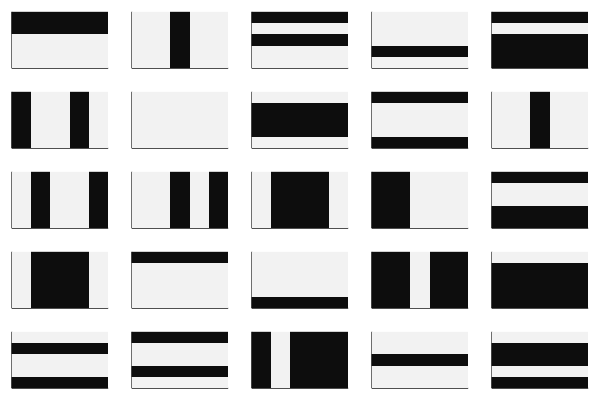

In [129]:
using Random
using Plots

n = 5
nbatch = 25

function bars_and_stripes(nbatch = 10)
    data = []
    for i in 1:nbatch
        S = Int64[]
        while length(S) == 0 #Ensures length(S) is not 0 so we get truly uniform distribution over the whole bars and stripes dataset
            randsubseq!(S, collect(1:n), 0.5)
        end
        if 1 in S
            b = repeat(Bool[1], n)
        else
            b = repeat(Bool[0], n)
        end
        for i in 2:n
            temp = repeat(Bool[0], n)
            if i in S
                temp = repeat(Bool[1], n)
            end
            b = hcat(b, temp)
        end
        flip = rand() < 0.5
        if length(S) == n
            ret = flip ? b : .!b
        else
            ret = flip ? b : rotl90(b)
        end
        push!(data, ret)
    end
    return data
end

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in bars_and_stripes(nbatch)]...)

In [21]:
using Combinatorics
using Plots

#Query
#Pick a random subset of {1,...,n} (could be empty or the entire set), then flip a coin (corresponds to rows or columns)
#parameters: nbatch, n

n = 4

#modification: sample s uniformly at random from all possible subsets, run make_data, and also with half probability, do rotl90
function make_data(s)
    if 1 in s
        b = Bool[1 1 1]
    else
        b = Bool[0 0 0]
    end
    for i in 2:n
        if i in s
            b = vcat(b, Bool[1 1 1])
        else
            b = vcat(b, Bool[0 0 0])
        end
    end
    return b
end

my_set = Set(1:n)

# Generate all subsets
all_subsets = powerset(collect(my_set))

data = []

for subset in all_subsets
    push!(data, make_data(subset))
end

for i in 2:(2^n - 1)
    push!(data, data[i] |> rotl90)
end

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data]...)

# Iterate over all subsets
# for subset in all_subsets
#     println(Set(subset))
# end

println(data[1])


Bool[0 0 0; 0 0 0; 0 0 0; 0 0 0]


Bool[0 0 1; 0 0 1; 0 0 1]

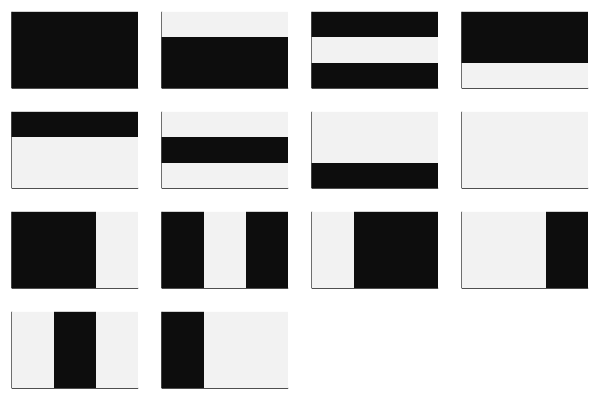

In [6]:
using Plots

data_train = []

push!(data_train,Bool[0 0 0;0 0 0; 0 0 0])
push!(data_train,Bool[0 0 0;0 0 0; 1 1 1])
push!(data_train,Bool[0 0 0;1 1 1; 0 0 0])
push!(data_train,Bool[1 1 1;0 0 0; 0 0 0])
push!(data_train,Bool[1 1 1;1 1 1; 0 0 0])
push!(data_train,Bool[1 1 1;0 0 0; 1 1 1])
push!(data_train,Bool[0 0 0;1 1 1; 1 1 1])
push!(data_train,Bool[1 1 1;1 1 1; 1 1 1])

print(data_train[2] |> rotl90)

for i in 2:7
    push!(data_train, data_train[i] |> rotl90)
end

# for d in data_train
#     print(d)
# end
# for d in data_train
#     push!(data_train, rotl90(d))
# end

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...)

In [8]:
using Random
using Plots

function generate_bars_and_stripes(n_samples, image_size)
    dataset = []
    labels = []

    for i in 1:n_samples
        # Randomly choose whether to generate a bar or a stripe
        is_bar = rand([true, false])

        # Generate the image
        if is_bar
            image = hcat(fill(1, image_size)...)
            label = 1  # 1 represents a bar
        else
            image = vcat(fill(1, image_size)...)
            label = 0  # 0 represents a stripe
        end

        push!(dataset, image)
        push!(labels, label)
    end

    return hcat(dataset...), labels
end

function plot_bars_and_stripes(data, labels, image_size)
    n_samples = length(labels)
    plot_grid = reshape(data, image_size, image_size, n_samples)

    plot_array = []
    for i in 1:n_samples
        push!(plot_array, heatmap(1:image_size, 1:image_size, plot_grid[:, :, i], c=:grays, color=:black, axis=false))
    end

    plot(plot_array..., layout=(1, n_samples), legend=false)
end

# Example usage
n_samples = 10
image_size = 5
data, labels = generate_bars_and_stripes(n_samples, image_size)
plot_bars_and_stripes(data, labels, image_size)

ArgumentError: ArgumentError: number of rows of each array must match (got (5, 5, 1, 5, 1, 1, 1, 5, 5, 5))

In [14]:
using Flux

function create_cnn()
    return Chain(
        Conv((3, 3), 1=>16, relu, bias = false), #Want to train 16 kernels, params = each entry in the kernel + the bias
        # MaxPool((2, 2)),
        # Conv((3, 3), 16=>32, relu),
        # MaxPool((2, 2)),
        # Flux.flatten,
        # Dense(50, 20, relu),
        # Dense(20, 10)
    )
end

function nparams(model)
    sum(length, Flux.params(model))
end

n = create_cnn()
Flux.params(n)
print(nparams(n))

144

In [4]:
using Yao
using FLOYao

nbatch = 10
yao_reg = zero_state(4; nbatch)
floyao_reg = FLOYao.zero_state(4; nbatch)

BatchedArrayReg{2, ComplexF64, Transpose...}
    active qubits: 4/4
    nlevel: 2
    nbatch: 10

In [2]:
function asdf(; a = 2, b = 3)
    a + b
end

result = asdf(b = 5)
println(result)  # This will correctly print 7

if 2<3 & 3<4
    print(5)
end

7
5

In [2]:
using Yao
using FLOYao
using Statistics

N = 2

g = chain(N)
push!(g, rot(kron(N, 1 => X, 2 => X), 0.)) #Rxx on two qubits
dispatch!(g, [0.3])

t = zero_state(N)
t |> g |> probs |> println

dispatch!(g, [0.3 + 2π])

t = zero_state(N)
t |> g |> probs |> println

[0.9776682445628029, 0.0, 0.0, 0.02233175543719699]
[0.9776682445628031, 0.0, 0.0, 0.02233175543719693]


In [41]:
using Yao
using FLOYao
using Statistics

N = 2

g = chain(N)
push!(g, rot(kron(N, 1 => X, 2 => X), 0.)) #Rxx on two qubits
dispatch!(g, rand(nparameters(g)).*2π)
theta = first(parameters(g))
println("true gradient: ", sin(theta)/2)

function loss(theta = theta)
    sin(theta/2)^2
end

ratio = 0
function pprior() #For each square, probability ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

function postprocess(g_output::Vector) #turns the output of reg |> g |> measure into an Int vector
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

samplemean_batch = 5000
function run_g(nbatch = samplemean_batch)
    samples = []
    for i in 1:nbatch
        z = pprior() #MajoranaReg object
        result = z |> g |> measure |> postprocess
        if i == 1
            samples = result
        else
            samples = hcat(samples, result) #is this operation slow; on another note there has to be a better way to write this function right
        end
    end
    samples
end
#outputs an N * #samples matrix

function run_d_fake(samples)
    # if size(samples)[1] != N || typeof(samples) != Matrix{Int64} #Require samples to be an N x #samples matrix
    #     println("Improper formatting of samples")
    #     return
    # end
    # samples |> d
    mean(samples, dims = 1)
end

function gLoss(nbatch = samplemean_batch)
    #-mean(log.(run_d_fake(run_g(nbatch))))
    mean(run_d_fake(run_g(nbatch)))
end

eps = 1e-5
function finitediff_grad(g = g, eps = eps) #Computes forward finite differences
    original = gLoss()
    println("original loss: $original")
    a = loss(theta)
    println("original true loss: $a")
    temp_params = parameters(g)
    grad = zeros(nparameters(g))
    temp = 0
    for i in 1:nparameters(g)
        plus = 0
        temp = parameters(g)[i]
        temp_params[i] = temp + eps
        dispatch!(g, temp_params)
        plus = gLoss()
        println("plus: $plus")
        b = loss(theta + eps)
        println("plus true loss: $b")
        grad[i] = (plus - original) / eps #(L(θ+ε_i) - L(θ))/ε; L is computed by sample means
        println("true finitediff: ", (b-a) / eps)
        println(plus - original)
        println(b - a)
        temp_params[i] = temp
        dispatch!(g, temp_params)
    end
    grad
end

function parametershift_grad()
    temp_params = parameters(g)
    grad = zeros(nparameters(g))
    for i in 1:nparameters(g)
        plus = 0
        minus = 0
        temp = parameters(g)[i]
        temp_params[i] = temp + π/2
        dispatch!(g, temp_params)
        plus = gLoss()
        temp_params[i] = temp - π/2
        dispatch!(g, temp_params)
        minus = gLoss()
        grad[i] = (plus - minus) / 2
        temp_params[i] = temp
        dispatch!(g, temp_params)
    end
    grad
end

finitediff_grad() |> println
parametershift_grad() |> println


true gradient: 0.42957693580613227
original loss: 0.7596


original true loss: 0.7558586645462962
plus: 0.7586
plus true loss: 0.7558629603028613
true finitediff: 0.4295756565020347
-0.0010000000000000009
4.295756565020348e-6
[-100.00000000000009]


[0.4304]


In [ ]:
g = chain(N)
push!(g, rot(kron(N, 1 => X, 2 => X), 0.)) #Rxx on two qubits
dispatch!(g, rand(nparameters(g)).*2π)

batch = 100
function gLoss(nbatch = batch)
    
end

function parametershift_grad()
    temp_params = parameters(g)
    grad = zeros(nparameters(g))
    for i in 1:nparameters(g)
        plus = 0
        minus = 0
        temp = parameters(g)[i]
        temp_params[i] = temp + 0.5 #CHECK HOW SCALING WORKS FOR PARAMETERS
        dispatch!(g, temp_params)
        plus = gLoss()
        temp_params[i] = temp - 0.5
        dispatch!(g, temp_params)
        minus = gLoss()
        grad[i] = (minus - plus) / 2
        temp_params[i] = temp
        dispatch!(g, temp_params)
    end
    grad
end


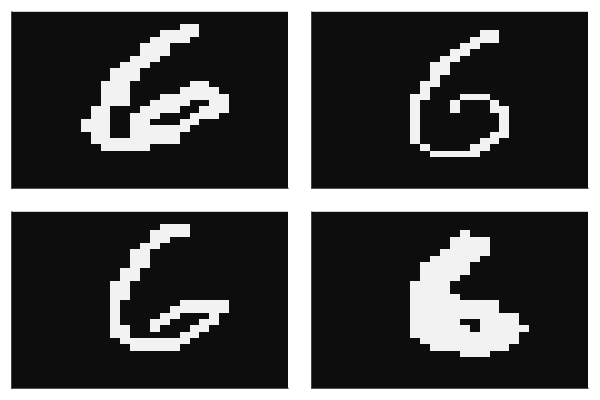

In [6]:
train = 4
digit = 6

train_set = MNIST(:train)
train_labels = MNIST(split=:train).targets

data_train = []
c = 1
for _ in 1:train
    while train_labels[c] != digit
        c += 1
    end
    push!(data_train, rotl90(train_set[c][1]) .> 0.5)
    c += 1
end

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...) #Is there any way to make this look nicer? oh well it's not a big deal

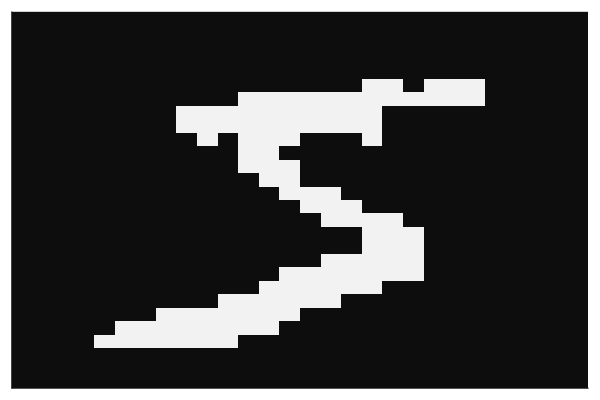

In [13]:
using MLDatasets
using Plots
using Pipe

train_set = MNIST(:train)

x = train_set[1][1] .> 0.5
#plot(heatmap(rotl90(x), color=:grays, colorbar = false, ticks = false))

@pipe x |> vec |> reshape(_,28,28) |> plot(heatmap(rotl90(_), color=:grays, colorbar = false, ticks = false))

In [11]:
using Yao

N = 25
layers = 5
g = chain(N) #Making the generator, which is a matchgate ansatz
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.))
    end
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end

dispatch!(g, :random)
println(parameters(g))
println(gradient(g))

[0.5454626686557851, 0.7574492625513849, 0.8288533351588325, 0.8121839130737354, 0.12552915101072648, 0.9449062360449023, 0.5463687791664117, 0.09229772257843483, 0.5568924549066308, 0.5606486321948967, 0.010461406276843888, 0.9396887583769711, 0.5033459341696521, 0.1588589384576673, 0.20351001955108505, 0.023185381445060105, 0.020737005973914036, 0.7693453064289135, 0.4291949836119133, 0.038512856382333926, 0.4138697495045821, 0.3528613744291771, 0.0886504059715808, 0.7546837896669328, 0.9065112630180457, 0.014435950938044062, 0.31341134606466803, 0.8191564311438772, 0.014977154750417832, 0.19440099431543445, 0.022222811440033463, 0.2803969484485763, 0.1863378011903839, 0.9780947319509354, 0.9770000768581694, 0.9695813150441435, 0.22121343888594558, 0.5430396689439804, 0.8361670777653141, 0.4457170689144183, 0.29415865993639234, 0.6995218848765529, 0.773505573960813, 0.8338676902023647, 0.6136888339641369, 0.42417479772483313, 0.44765139314548197, 0.23702216203722126, 0.89792802578365

UndefVarError: UndefVarError: `gradient` not defined

In [21]:
using Yao
circuit = chain(4, repeat(4, H, 1:4), put(4, 3=>Rz(0.5)), control(2, 1=>X), put(4, 4=>Ry(0.2)))
circuit = circuit |> Yao.autodiff(:BP) #???????

UndefVarError: UndefVarError: `autodiff` not defined

In [7]:
using Flux

# Define a simple neural network
model = Chain(Dense(10, 5, relu), Dense(5, 2))

# Display the initial parameters
println("Initial Parameters:")
for p in params(model)
    println(p)
end
const initial = params
params = params(model)
println("initial: ", initial)

# Suppose you have new parameter values as vectors (of the correct dimensions)
new_params_layer1 = randn(5, 10)
new_params_layer2 = randn(5)
new_params_layer3 = randn(2, 5)
new_params_layer4 = randn(2)

# Set the new parameters
println("length ", length(params(model)))
params_layer1, params_layer2, params_layer3, params_layer4 = params(model)
println(size(params_layer1))
println(size(params_layer2))
println(size(params_layer3))
println(size(params_layer4))
params_layer1 .= new_params_layer1  # Use broadcasting assignment .=
params_layer2 .= new_params_layer2
params_layer3 .= new_params_layer3
params_layer4 .= new_params_layer4
println("initial: ", initial)

# Display the updated parameters
println("\nUpdated Parameters:")
for p in Flux.params(model)
    println(p)
end

new_params_layer1, new_params_layer2, new_params_layer3, new_params_layer4 = initial
println("asdf ", new_params_layer1)
params_layer1, params_layer2, params_layer3, params_layer4 = params(model)
params_layer1 .= new_params_layer1  # Use broadcasting assignment .=
params_layer2 .= new_params_layer2
params_layer3 .= new_params_layer3
params_layer4 .= new_params_layer4

println("\nInitial Parameters:")
for p in Flux.params(model)
    println(p)
end


Initial Parameters:
Float32[0.2586 0.2564478 -0.14705507 -0.6034778 -0.006969022 -0.55017704 -0.6041567 -0.5692597 0.5514455 0.40842122; 0.37690863 0.123033695 0.05006682 0.4423845 -0.63022286 0.43721518 -0.5289191 -0.38148215 0.47268787 -0.30389434; 0.18071061 0.6046077 0.25994346 0.4808553 -0.47517708 0.51701206 0.19030918 0.07959194 -0.48305234 0.037443433; 0.45869675 -0.21159495 -0.19798404 0.5784383 -0.0682152 -0.3134224 0.07947719 0.60297364 -0.3178038 0.28330582; 0.450709 -0.44164377 -0.38924357 0.023509612 -0.22734238 0.25996125 -0.3176807 -0.3897135 0.3003256 0.34115252]
Float32[0.0, 0.0, 0.0, 0.0, 0.0]
Float32[-0.46451345 -0.7161916 0.30781022 -0.5166258 -0.29030392; -0.772016 0.45951253 -0.09930434 0.38461727 -0.91004753]
Float32[0.0, 0.0]


ErrorException: cannot assign a value to imported variable Flux.params from module Main

In [23]:
using Flux
using LinearAlgebra
using Random

Random.seed!(2)

function n(a::Vector)
    return a[1]
end

model = Chain(
    Dense(4, 2, relu),
    Dense(2, 1),
    softmax
)

println(sum(length, Flux.params(model)))

data = [([1,2,3,4], 2), ([2,3,4,5], 3), ([3,4,5,6], 3)]
x = [1,2,3,4]
y = 2
loss3(m, x, y) = norm(m(x) .- y)     # the model is the first argument

opt_state = Flux.setup(Adam(), model)

initial = Flux.params(model)
println("asdf ", initial)
# for p in Flux.params(model)
#     p .= (ones(size(p)) .* 0.08)
# end

# epochs = 10
# for i in 1:epochs
#     Flux.train!(loss3, model, data, opt_state) 
#     s = 0
#     for d in data
#         s += loss3(model, d[1], d[2])
#     end
#     println("iteration $i: loss is $s")
# end

A = zeros(2,2)
setindex!(A, [10,20], [1,2])
A[[3, 4]] = [30, 40]
println(A)

println(Flux.params(model))

Flux.train!(loss3, model, data, opt_state)
#nparams = sum(length, Flux.params(model))

# for i in 1:nparams
#     #Flux.params(model)[i] = initial[i]
#     setindex!(Flux.params(model), initial[i],)
# end

println(Flux.params(model))

13
asdf Params([Float32[-0.82332647 -0.59481263 -0.40093803 0.38192046; -0.9954989 0.3614949 0.47065997 0.6134633], Float32[0.0, 0.0], Float32[0.017256774 -0.73138165], Float32[0.0]])
[10.0 30.0; 20.0 40.0]
Params([Float32[-0.82332647 -0.59481263 -0.40093803 0.38192046; -0.9954989 0.3614949 0.47065997 0.6134633], Float32[0.0, 0.0], Float32[0.017256774 -0.73138165], Float32[0.0]])
Params([

Float32[-0.82332647 -0.59481263 -0.40093803 0.38192046; -0.9954989 0.3614949 0.47065997 0.6134633], Float32[0.0, 0.0], Float32[0.017256774 -0.73138165], Float32[0.0]])


In [2]:
using Flux

# model = Chain(
#     Dense(4, 2, relu),
#     Dense(2, 1),
#     softmax
# )

# println(Flux.params(model))
# x = rand(Float32, 4)
# println(x)
# model(x)

model2 = Chain(
  Dense(10 => 5, σ),
  Dense(5 => 2),
  softmax)

x = rand(10)
y = rand(10)
model2(x) |> println
model2(y) |> println
hcat(x,y)
#model2(hcat(x,y))

Float32[0.5029387, 0.4970613]
Float32[0.52733314, 0.47266683]


10×2 Matrix{Float64}:
 0.0262499  0.979999
 0.332267   0.141428
 0.75646    0.554159
 0.154411   0.393257
 0.461534   0.627533
 0.818963   0.352821
 0.912385   0.921515
 0.948366   0.962068
 0.104596   0.253137
 0.736038   0.346649

In [ ]:
using Flux

N = 196

function NeuralNetwork(num_dim = N, random = true)
    net = Chain(Dense(num_dim, 25, relu), Dense(25, 1, x -> σ.(x)))
    if !random
        for p in Flux.params(net)
            p .= ones(size(p)) .* 0.08
        end
    end
    return x -> first(net(x))
end


d = NeuralNetwork()
d(ones(196))

In [ ]:
function dLoss(data::Vector) #the first half of data is D's output on real, the second half is D's output on fake
    len = length(data)÷2
    real = data[1:len]
    fake = data[len+1:end]
    (sum(log.(real)) + sum(log.(1 .- fake))) / len
end

print(dLoss([0.5,0.5,0.5,0.5]))

In [ ]:
using FLOYao

a = FLOYao.zero_state(4)

typeof(a)

In [ ]:
using Plots

# Sample data (matrices)
data_matrices = [rand(3, 3) for _ in 1:4]  # Create an array of 4 random 3x3 matrices

# Create an array of heatmap plots
heatmaps = [heatmap(data_matrix, title="Heatmap $i", color=:grays, c=:auto) for (i, data_matrix) in enumerate(data_matrices)]

# Combine the heatmaps into a single plot
plot(heatmaps..., layout=(2, 2))  # Arrange heatmaps in a 2x2 grid


In [ ]:
using Flux

# # Create a sample input tensor (4x4) with random values
# input_tensor = rand(4, 4)

# # Perform average pooling with a pooling size of 2x2 and a stride of 2
# pooled_tensor = Flux.MeanPool(input_tensor, (2, 2), (2, 2))

# println("Original tensor:")
# println(input_tensor)
# println("Pooled tensor:")
# println(pooled_tensor)


xs = rand(Float32, 100, 100, 3, 50);

m = Chain(Conv((5,5), 3 => 7), MeanPool((5,5), pad=SamePad()))
Chain(
  Conv((5, 5), 3 => 7),                 # 532 parameters
  MeanPool((5, 5), pad=2),
)

m[1](xs) |> size
#(96, 96, 7, 50)

m(xs) |> size
#(20, 20, 7, 50)

In [ ]:
using Flux

function NeuralNetwork()
    return Chain(
            Dense(2, 25,relu),
            Dense(25,1,x->σ.(x))
            )
end

m = NeuralNetwork()

#Flux.params(m)

print(m([1,2]))

In [ ]:
image_size = 5
N = image_size * image_size

ratio = 1/2
function pprior() #For each square, probability 1/ratio that it's white, where ratio ~ N(mean(data), std(data)); maybe we can vary pprior later?
    return rand(N) .< ratio
end

x = Int.(pprior())
x |> println

#heatmap(rotl90(reshape(x, image_size, image_size)) .> 0.5, color=:grays, colorbar = false, ticks = false)

using FLOYao
using Yao

state1 = FLOYao.product_state([0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0])
eeeee = FLOYao.product_state(x) 



In [ ]:
using Yao
using FLOYao

n = 4
t = FLOYao.rand_state(n)
print(typeof(t))

t |> probs |> println

v = state(t)
sum =  0
for x in v
    sum += abs2(x)
end
println(sum)

In [1]:
using Yao

N = 16
layers = 5
g = chain(N) #Making the generator, which is a matchgate ansatz
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.))
    end
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end

dispatch!(g, :random)
arr = parameters(g)
println(parameters(g))
print(typeof(ones(155)))
dispatch!(+, g, ones(155))
println(parameters(g))
println(parameters(g) == (arr .+ 1))

[0.4186772651923395, 0.9443010326818442, 0.9604670690207017, 0.5014306245878104, 0.014814455133769333, 0.6637267892324535, 0.8004070214160125, 0.9933734646203043, 0.49515398288064283, 0.6727919478530155, 0.9453560786450677, 0.710193597552303, 0.07214187955821183, 0.8230923362961615, 0.08832122393214437, 0.40454056488880863, 0.7390263600292579, 0.5797557119669229, 0.30810036517773787, 0.6289055969175638, 0.5962374481127165, 0.6674566970526364, 0.3979664999995305, 0.2099511355743473, 0.4881279629787322, 0.721705513844638, 0.5959050022663406, 0.5104686890941542, 0.0906731497983767, 0.4016255460353315, 0.19651094999005136, 0.7133541848227378, 0.2259995313122779, 0.785819033906092, 0.35806641608012, 0.19741465119134816, 0.8937175847359243, 0.6891482434572337, 0.11512139314014469, 0.06888338178360953, 0.7300923035673231, 0.07082591622038015, 0.29573783538328047, 0.26422556923924934, 0.3990292986480022, 0.23689209314395354, 0.6309343564611205, 0.5260734735640302, 0.2257064801596993, 0.4843902

Vector{

Float64}

[1.4186772651923394, 1.9443010326818442, 1.9604670690207016, 1.5014306245878104, 1.0148144551337692, 1.6637267892324537, 1.8004070214160124, 1.9933734646203043, 1.4951539828806428, 1.6727919478530155, 1.9453560786450677, 1.710193597552303, 1.0721418795582118, 1.8230923362961615, 1.0883212239321445, 1.4045405648888085, 1.739026360029258, 1.5797557119669228, 1.3081003651777379, 1.6289055969175639, 1.5962374481127166, 1.6674566970526365, 1.3979664999995305, 1.2099511355743473, 1.4881279629787323, 1.721705513844638, 1.5959050022663406, 1.510468689094154, 1.0906731497983766, 1.4016255460353315, 1.1965109499900515, 1.7133541848227378, 1.225999531312278, 1.785819033906092, 1.3580664160801201, 1.1974146511913482, 1.8937175847359242, 1.6891482434572338, 1.1151213931401447, 1.0688833817836096, 1.7300923035673232, 1.0708259162203801, 1.2957378353832805, 1.2642255692392492, 1.3990292986480022, 1.2368920931439535, 1.6309343564611205, 1.5260734735640302, 1.2257064801596993, 1.484390236773382, 1.4550